# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

import cProfile
import re
import time

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Solve, Statistics, Classes, Big_Class, FileFuncs

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
# comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

### Roie Larger Network

In [3]:
# User variables

NGrid = 16  # lattice dimension is Ngrid X Ngrid
# NGrid = 3  # lattice dimansion is Ngrid X Ngrid

# task_type = 'Allostery_one_pair'  # 1 pair of input and outputs
task_type = 'Allostery'  # 2 pairs of input and outputs
# task_type = 'Flow_clockwise'  # 2 pairs of input and outputs, test is flowing from both inputs to both outputs
# task_type = 'XOR'  # 2 inputs and 2 outputs. difference between output nodes encodes the XOR result of the 2 inputs
# task_type = 'Channeling_diag'  # 1st from input to diagonal output, then from output to 2 perpindicular nodes. 
#                                # test from input to output
# task_type = 'Channeling_straight' # 1st from input to output on same column, then from output to 2 perpindicular nodes. 
#                                   # test from input to output (same as 1st)
    
# row = int(np.floor(np.sqrt(NGrid))-1)  # row (and column) of input and output nodes in the NGrid X NGrid cell array
row = 2

# Assign input and output nodes a.f.o lattice size and row choice
input_output_pairs, fixed_node_pairs = Constraints.build_input_output_and_fixed(task_type, row, NGrid)

## These are defaults
# Periodic = False  # flag for lattice periodicity
# net_typ = 'Cells'  # layout for NETfuncs plotNetStructure(). 'Cells' is my style of network and is default
# u_thresh = 1  # threshold to move marbles

# Schemes to change conductivities and order of pressure appliance in training and test
if task_type == 'Allostery_one_pair':
    K_scheme = 'propto_current_squared'
    flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
elif task_type == 'Channeling_straight' or task_type == 'Channeling_diag':
    K_scheme = 'marbles_pressure'
    flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
else:
    K_scheme = 'marbles_pressure'
    flow_scheme = 'unidir'  # apply pressure drop only in the regular directions - constrained node = positive, ground = 0
                            # there are 2 input and output pairs, exchange between them
    # flow_scheme = 'taktak'  # apply pressure drop unidir once, meaning 1st input and output pair and then 2nd pair.
                              # then switch ground and constrained nodes to apply oposite dir.

# K_type = 'bidir'  # conductivity is the same regardless of flow directions
K_type = 'flow_dep'  # conductivity depends on flow direction - if into cell then maximal, 
                     # if out and there is a marble then lower

# Only for conductivity proportional to current squared scheme    
beta = 10**(-2)
# beta = 0
# print('beta is:' + str(beta))

K_max = 1
# K_min = np.array([0.1])
# K_min = np.array([0.0001, 0.01, 0.1, 0.3, 0.5])
# K_min = np.array([0.03, 0.04])
# K_min = np.array([1/(4*(NGrid-2*row)-1)])  # theoretical marginal for channeling
K_min = np.logspace(-2.2, -0.0001, num=50, base=10)

# input_p = arange(0.1, 7, 0.16)
input_p = np.logspace(1.2, 2.2, num=50, base=10)
# input_p = np.array([3.2, 32, 320, 600, 6000])
# input_p = np.array([600])

iterations = 16  # # iterations allowed under flow cycles / updating conductivities

In [4]:
## Prints

print('input output node pairs are:\n' + str(input_output_pairs) +'\n')

print('pressure is:')
for i in input_p:
    print(i)
    
print('\n K min is:')
for i in K_min:
    print(i)

input output node pairs are:
[[ 174 1054]
 [1109  229]]

pressure is:
15.848931924611133
16.61147371250843
17.410703775745386
18.24838730223532
19.12637440861443
20.046604226428844
21.011109184920898
22.022019499873757
23.08156787842828
24.192094450263586
25.356051936031946
26.576011064463433
27.854666250104376
29.194841544229647
30.59949687207196
32.071734570143846
33.61480623809065
35.23211992020768
36.927247632482604
38.703933251787525
40.5661007846448
42.5178630338289
44.56353068194607
46.70762181205299
48.95487188634263
51.310244204935685
53.778940867877445
56.36641426455055
59.078379115879464
61.92082509592316
64.9000300607321
68.0225739136873
71.29535313794352
74.72559602807513
78.32087865456273
82.08914159638262
86.03870747865233
90.1782993540685
94.51705996873221
99.0645719549143
103.83087899535762
108.82650800586015
114.06249238513215
119.55039638327577
125.30234064271025
131.33102896794904
137.64977638335696
144.27253854085185
151.213942542505
158.48931924611142

 K min is:


In [5]:
## Variables class - mostly user choices

Variabs = Classes.User_variables(NGrid, input_p, flow_scheme, task_type, K_scheme, K_type, iterations, input_output_pairs, 
                                 Periodic='False', net_typ='Cells', u_thresh=1, fixed_node_pairs=fixed_node_pairs, 
                                 K_max=K_max, K_min=K_min, beta=beta)

In [6]:
## Big Class containing all classes in Network Simulation

BigClass = Big_Class.Big_Class(Variabs)

In [7]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)
BigClass.add_Strctr(Strctr)  # add to big class

In [8]:
## Initiate internal flow network state class

State = Classes.Net_state()
BigClass.add_State(State)  # add to big class

NET is ready


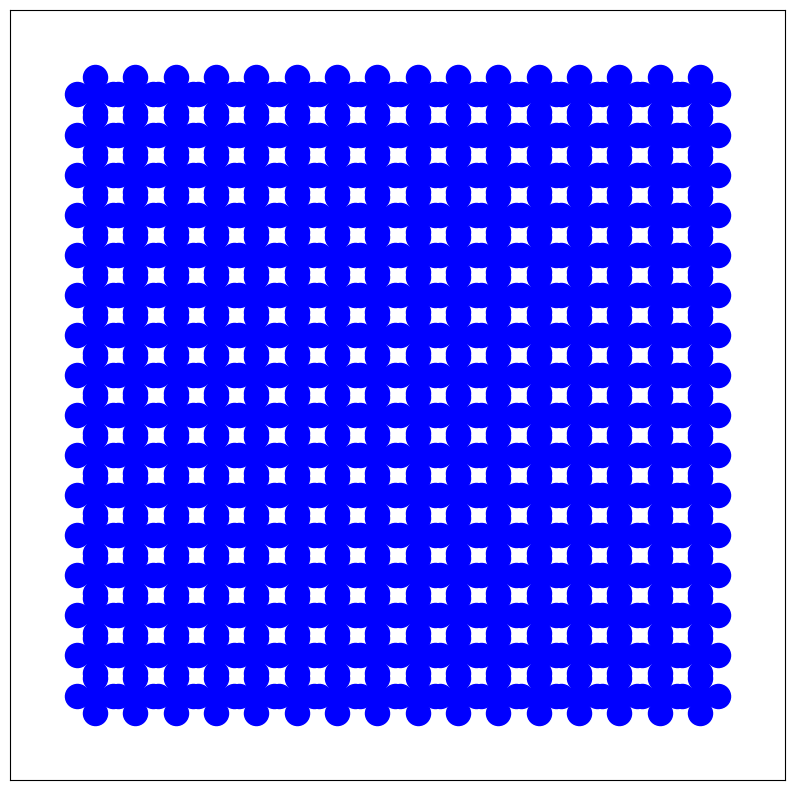

NET is ready


In [9]:
## build network graphics class and plot structure

NET = Classes.Networkx_net()
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass)
pos_lattice = NETfuncs.plotNetStructure(NET.NET, plot='yes', node_labels=False)  # position lattice, datatype of networkx
BigClass.add_NET(NET)  # add to big class

### Main part - loop over both cond and pressure

In [10]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
power_dissip_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
convergence_time_vec = np.zeros([len(K_min), len(input_p) ])
shear_vec = np.zeros([len(K_min), len(input_p)])  # 
u_allostery_arr = np.zeros([2, 2, len(K_min), len(input_p)])  # 

# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(BigClass)

print('started main loop')
for i, K_min_i in enumerate(K_min):
    
    # K min into Variabs Class 
    Variabs.assign_K_min(K_min_i)
    
    for j, p in enumerate(input_p):
        
        start = time.time()  # time start of calculation for profiling

        # input pressure into Variabs Class
        Variabs.assign_input_p(p)

        # Set up constraints for whole loop
        Strctr.Setup_constraints(BigClass)

        # Initiate K matrix again, not mandatory, better not doing it actually
        State.initiateK(BigClass, noise='rand_u', noise_amp=0.25)
        # print(State.K)

        # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
        #        change constraints and repeat
        State.flow_iterate(BigClass, sim_type='w marbles', plot='no', savefig='no')
        # State.flow_iterate(Variabs, Strctr, NET, sim_type='w marbles', plot='yes', savefig='yes')
        
        # print(State.K)

        MSE_arr[:, i, j] = State.MSE
        Hamming_arr[:, i, j] = State.Hamming
        # print(State.power_dissip)
        power_dissip_arr[:, i, j] = State.power_dissip
        convergence_time_vec[i, j] = State.convergence_time
        
        State.flow_iterate(BigClass, sim_type='allostery test', plot='no', savefig='no')  # flow from both inputs
                                                                                           # to both outputs
        
#         p_mat = Statistics.p_mat(State.p, BigClass.Variabs.NGrid)
#         R_typ = (1/1 + 1/1) * (NGrid-(2*row)) + 2
#         u_typ = input_p[0]/R_typ
#         w_ij = Statistics.curl_direction(State.u, BigClass.Variabs.NGrid)  # calculate curl/vorticity
        
#         w_vec[i, j] = w_ij/u_typ
#         print('w_ij_norm %f' % w_vec[i, j])
        
        # FileFuncs.save_csv_files_Net(BigClass, p, K_min_i, comp_path)
      
        u_allostery_arr[:,:, i, j] = State.u_final
        shear_vec[i, j] = Statistics.shear_type(State.u_final)
        print('shear is: ' + str(shear_vec[i]))

        end = time.time()  # time end of calculation for profiling
        dt = end-start  # total time it took to run calculation
        print('total time for simulation %f' %dt)
    
    print(str((i+1)*100/len(K_min)) + '% done')
        
convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

started main loop
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.04554213 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 13.327496
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 3
cycle # 3
# iterations 2
cycle # 3
# iterations 2
cycle # 4
# iterations 2
cycle # 4
# iterations 2
loop break
cycle # 0
cycle # 0
she

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 2
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 4.55421252e-02  7.00547625e-02  4.88415312e-02  1.03058656e-02
  5.89095726e-02  1.38591869e-01  4.39468194e-03  2.94472212e-03
  4.28729636e-03 -9.10713287e-05  3.12765827e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 5
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 5
cycle # 4
# iterations 3
cycle # 4
# iterations 4
cycle # 5
# iterations 4
cycle # 5
# iterations 4
cycle # 6
# iterations 3
cycle # 6
# iterations 3
cycle # 7
# iterations 5
cycle # 7
# iterations 4
cycle # 0
cycle # 0
shear is: [ 4.55421252e-02  7.00547625e-02  4.88415312e-02  1.03058656e-02
  5.89095726e-02  1.38591869e-01  4.39468194e-03  2.94472212e-03
  4.28729636e-03 -9.10713287e-05  3.12765827e-03  2.95573245e-03
  2.14689801e-03  3.26392781e-03  5.60417158e-03 -6.74379370e-03
  9.74976467e-03 -3.59580534e-03  6.03480838e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 6
cycle # 2
# iterations 7
cycle # 3
# iterations 8
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
cycle # 5
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 4.55421252e-02  7.00547625e-02  4.88415312e-02  1.03058656e-02
  5.89095726e-02  1.38591869e-01  4.39468194e-03  2.94472212e-03
  4.28729636e-03 -9.10713287e-05  3.12765827e-03  2.95573245e-03
  2.14689801e-03  3.26392781e-03  5.60417158e-03 -6.74379370e-03
  9.74976467e-03 -3.59580534e-03  6.03480838e-03  3.94265622e-03
  2.22112919e-03  2.35346887e-03  7.93211186e-04  1.24932935e-02
  1.92014907e-02  1.46203065e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000

# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 8
cycle # 2
# iterations 8
cycle # 2
# iterations 4
cycle # 3
# iterations 6
cycle # 3
# iterations 7
cycle # 4
# iterations 7
cycle # 4
# iterations 7
cycle # 5
# iterations 8
cycle # 5
# iterations 6
cycle # 6
# iterations 8
cycle # 6
# iterations 6
cycle # 7
# iterations 7
cycle # 7
# iterations 7
cycle # 0
cycle # 0
# iterations 1
shear is: [ 4.55421252e-02  7.00547625e-02  4.88415312e-02  1.03058656e-02
  5.89095726e-02  1.38591869e-01  4.39468194e-03  2.94472212e-03
  4.28729636e-03 -9.10713287e-05  3.12765827e-03  2.95573245e-03
  2.14689801e-03  3.26392781e-03  5.60417158e-03 -6.74379370e-03
  9.74976467e-03 -3.59580534e-03  6.03480838e-03  3.94265622e-03
  2.22112919e-03  2.35346887e-03  7.93211186e-04  1.24932935e-02
  1.92014907e-02  1.46203065e-02  1.23972168e-02  6.61824234e-03
  1.18567630e-02  1.56934604e-02  1.34122619e-02  2.75135608e-02
  1.52571169e-02  0.00000000e+00  0.00000000e

# iterations 7
cycle # 0
# iterations 6
cycle # 1
# iterations 6
cycle # 1
# iterations 9
cycle # 2
# iterations 8
cycle # 2
# iterations 8
cycle # 3
# iterations 5
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [ 4.55421252e-02  7.00547625e-02  4.88415312e-02  1.03058656e-02
  5.89095726e-02  1.38591869e-01  4.39468194e-03  2.94472212e-03
  4.28729636e-03 -9.10713287e-05  3.12765827e-03  2.95573245e-03
  2.14689801e-03  3.26392781e-03  5.60417158e-03 -6.74379370e-03
  9.74976467e-03 -3.59580534e-03  6.03480838e-03  3.94265622e-03
  2.22112919e-03  2.35346887e-03  7.93211186e-04  1.24932935e-02
  1.92014907e-02  1.46203065e-02  1.23972168e-02  6.61824234e-03
  1.18567630e-02  1.56934604e-02  1.34122619e-02  2.75135608e-02
  1.52571169e-02  1.51980106e-02  2.25486653e-03  2.44349943e-02
  1.70730099e-02  1.38733636e-02  2.10089940e-02  2.07601080e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.

# iterations 5
cycle # 0
# iterations 6
cycle # 1
# iterations 10
cycle # 1
# iterations 11
cycle # 2
# iterations 11
cycle # 2
# iterations 9
cycle # 3
# iterations 7
cycle # 3
cycle # 4
# iterations 9
cycle # 4
# iterations 7
cycle # 5
# iterations 9
cycle # 5
# iterations 8
cycle # 6
# iterations 7
cycle # 6
# iterations 8
cycle # 7
# iterations 10
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 4.55421252e-02  7.00547625e-02  4.88415312e-02  1.03058656e-02
  5.89095726e-02  1.38591869e-01  4.39468194e-03  2.94472212e-03
  4.28729636e-03 -9.10713287e-05  3.12765827e-03  2.95573245e-03
  2.14689801e-03  3.26392781e-03  5.60417158e-03 -6.74379370e-03
  9.74976467e-03 -3.59580534e-03  6.03480838e-03  3.94265622e-03
  2.22112919e-03  2.35346887e-03  7.93211186e-04  1.24932935e-02
  1.92014907e-02  1.46203065e-02  1.23972168e-02  6.61824234e-03
  1.18567630e-02  1.56934604e-02  1.34122619e-02  2.75135608e-02
  1.52571169e-02  1.51980106e-02  2.25486653e-03  2.44349943e-02
  1.70

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.0659717  0.06089564 0.1652842  0.03885796 0.00583952 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 23.567395
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [0.0659717  0.06089564 0.1652842  0.03885796 0

shear is: [0.0659717  0.06089564 0.1652842  0.03885796 0.00583952 0.00354053
 0.00541991 0.14080629 0.01196197 0.0132233  0.00338692 0.01393513
 0.00735271 0.01079693 0.00609224 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 27.471297
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.0659717  0.06089564 0.1652842  0.03885796 0.00583952 0.00354053
 0.00541991 0.14080629 0.01196197 0.0132233  0.00338692 0.01393513
 0.00735271 0.01079693 0.00609224 0.0065578  0.         0.
 0.         0.         0.         0.         0.         0.

# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 9
cycle # 2
# iterations 5
cycle # 3
# iterations 9
loop break
cycle # 0
cycle # 0
shear is: [ 0.0659717   0.06089564  0.1652842   0.03885796  0.00583952  0.00354053
  0.00541991  0.14080629  0.01196197  0.0132233   0.00338692  0.01393513
  0.00735271  0.01079693  0.00609224  0.0065578  -0.00121858 -0.00420291
  0.00509336 -0.0073749   0.00738062 -0.00223938  0.00280976  0.00438493
 -0.00570244  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 32.011266
cycle # 0
# iterations 4
cycle # 0
# iterations 6
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
loop 

# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 7
cycle # 1
# iterations 10
cycle # 2
# iterations 11
cycle # 2
# iterations 6
cycle # 3
# iterations 6
cycle # 3
# iterations 12
cycle # 4
# iterations 6
cycle # 4
# iterations 4
cycle # 5
# iterations 5
cycle # 5
# iterations 6
cycle # 6
# iterations 5
cycle # 6
# iterations 7
cycle # 7
# iterations 5
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.0659717   0.06089564  0.1652842   0.03885796  0.00583952  0.00354053
  0.00541991  0.14080629  0.01196197  0.0132233   0.00338692  0.01393513
  0.00735271  0.01079693  0.00609224  0.0065578  -0.00121858 -0.00420291
  0.00509336 -0.0073749   0.00738062 -0.00223938  0.00280976  0.00438493
 -0.00570244  0.00611141  0.00565184  0.00989036  0.00503063  0.00906781
  0.0107294   0.01050162  0.00810846  0.01821102  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

# iterations 7
cycle # 0
# iterations 5
cycle # 1
# iterations 12
cycle # 1
# iterations 14
cycle # 2
# iterations 9
cycle # 2
# iterations 13
cycle # 3
# iterations 7
cycle # 3
# iterations 7
cycle # 4
# iterations 9
cycle # 4
# iterations 9
cycle # 5
# iterations 5
cycle # 5
# iterations 8
cycle # 6
# iterations 9
cycle # 6
# iterations 9
cycle # 7
# iterations 5
cycle # 7
# iterations 8
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.0659717   0.06089564  0.1652842   0.03885796  0.00583952  0.00354053
  0.00541991  0.14080629  0.01196197  0.0132233   0.00338692  0.01393513
  0.00735271  0.01079693  0.00609224  0.0065578  -0.00121858 -0.00420291
  0.00509336 -0.0073749   0.00738062 -0.00223938  0.00280976  0.00438493
 -0.00570244  0.00611141  0.00565184  0.00989036  0.00503063  0.00906781
  0.0107294   0.01050162  0.00810846  0.01821102  0.01467561  0.01212645
  0.01977419  0.0210369   0.02642967  0.00549741  0.02097282  0.02275909
  0.          0.          0.          0.          0

# iterations 6
cycle # 0
# iterations 6
cycle # 1
# iterations 8
cycle # 1
# iterations 10
cycle # 2
# iterations 10
cycle # 2
# iterations 9
cycle # 3
# iterations 11
cycle # 3
# iterations 9
cycle # 4
# iterations 11
loop break
cycle # 0
cycle # 0
shear is: [ 0.0659717   0.06089564  0.1652842   0.03885796  0.00583952  0.00354053
  0.00541991  0.14080629  0.01196197  0.0132233   0.00338692  0.01393513
  0.00735271  0.01079693  0.00609224  0.0065578  -0.00121858 -0.00420291
  0.00509336 -0.0073749   0.00738062 -0.00223938  0.00280976  0.00438493
 -0.00570244  0.00611141  0.00565184  0.00989036  0.00503063  0.00906781
  0.0107294   0.01050162  0.00810846  0.01821102  0.01467561  0.01212645
  0.01977419  0.0210369   0.02642967  0.00549741  0.02097282  0.02275909
  0.01945296  0.02000667  0.01916232  0.02952707  0.0193811   0.02270556
  0.04172419  0.03334307]
total time for simulation 66.202745
4.0% done
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.05576659  0.01127718  0.00477334  0.00306086  0.00619868 -0.00090722
  0.0103216   0.00767555  0.00736893  0.00451554  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 22.007528
cycle # 0
# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# it

# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 5
cycle # 5
# iterations 4
cycle # 5
# iterations 6
cycle # 6
# iterations 5
cycle # 6
# iterations 4
cycle # 7
# iterations 4
cycle # 7
# iterations 5
cycle # 0
cycle # 0
shear is: [ 5.57665900e-02  1.12771842e-02  4.77334127e-03  3.06086209e-03
  6.19868197e-03 -9.07220397e-04  1.03215990e-02  7.67554526e-03
  7.36892648e-03  4.51554398e-03  3.67898828e-03  1.89315970e-02
  4.95461143e-03  6.57850397e-03 -4.21749536e-04 -1.10569684e-03
  9.35257991e-03  6.99623292e-05 -5.01311112e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 5
cycle # 3
# iterations 6
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 5.57665900e-02  1.12771842e-02  4.77334127e-03  3.06086209e-03
  6.19868197e-03 -9.07220397e-04  1.03215990e-02  7.67554526e-03
  7.36892648e-03  4.51554398e-03  3.67898828e-03  1.89315970e-02
  4.95461143e-03  6.57850397e-03 -4.21749536e-04 -1.10569684e-03
  9.35257991e-03  6.99623292e-05 -5.01311112e-03  6.74871432e-03
  1.03616802e-02 -2.08336698e-03  1.39137903e-02  1.01512614e-02
  5.52880452e-03  1.12365912e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 3
cycle # 4
# iterations 7
cycle # 4
# iterations 3
cycle # 5
# iterations 6
cycle # 5
# iterations 3
cycle # 6
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 5.57665900e-02  1.12771842e-02  4.77334127e-03  3.06086209e-03
  6.19868197e-03 -9.07220397e-04  1.03215990e-02  7.67554526e-03
  7.36892648e-03  4.51554398e-03  3.67898828e-03  1.89315970e-02
  4.95461143e-03  6.57850397e-03 -4.21749536e-04 -1.10569684e-03
  9.35257991e-03  6.99623292e-05 -5.01311112e-03  6.74871432e-03
  1.03616802e-02 -2.08336698e-03  1.39137903e-02  1.01512614e-02
  5.52880452e-03  1.12365912e-02  1.69846882e-02  1.86903338e-02
  4.03917452e-03  2.28808409e-02  1.39520122e-02  4.23209363e-03
  1.40280023e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000000

# iterations 5
cycle # 0
# iterations 6
cycle # 1
# iterations 6
cycle # 1
# iterations 8
cycle # 2
# iterations 8
cycle # 2
# iterations 13
cycle # 3
# iterations 7
cycle # 3
# iterations 8
cycle # 4
# iterations 7
loop break
cycle # 0
cycle # 0
shear is: [ 5.57665900e-02  1.12771842e-02  4.77334127e-03  3.06086209e-03
  6.19868197e-03 -9.07220397e-04  1.03215990e-02  7.67554526e-03
  7.36892648e-03  4.51554398e-03  3.67898828e-03  1.89315970e-02
  4.95461143e-03  6.57850397e-03 -4.21749536e-04 -1.10569684e-03
  9.35257991e-03  6.99623292e-05 -5.01311112e-03  6.74871432e-03
  1.03616802e-02 -2.08336698e-03  1.39137903e-02  1.01512614e-02
  5.52880452e-03  1.12365912e-02  1.69846882e-02  1.86903338e-02
  4.03917452e-03  2.28808409e-02  1.39520122e-02  4.23209363e-03
  1.40280023e-02  2.46780331e-02  1.46689189e-02  1.84295868e-02
  2.00589437e-02  2.06188579e-02  1.79050342e-02  9.56212452e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000

# iterations 7
cycle # 0
# iterations 4
cycle # 1
# iterations 8
cycle # 1
# iterations 7
cycle # 2
# iterations 9
cycle # 2
# iterations 10
cycle # 3
# iterations 8
cycle # 3
# iterations 6
cycle # 4
# iterations 5
cycle # 4
# iterations 8
cycle # 5
# iterations 5
cycle # 5
# iterations 9
cycle # 6
# iterations 8
cycle # 6
# iterations 9
cycle # 7
# iterations 7
cycle # 7
# iterations 8
loop break
cycle # 0
cycle # 0
shear is: [ 5.57665900e-02  1.12771842e-02  4.77334127e-03  3.06086209e-03
  6.19868197e-03 -9.07220397e-04  1.03215990e-02  7.67554526e-03
  7.36892648e-03  4.51554398e-03  3.67898828e-03  1.89315970e-02
  4.95461143e-03  6.57850397e-03 -4.21749536e-04 -1.10569684e-03
  9.35257991e-03  6.99623292e-05 -5.01311112e-03  6.74871432e-03
  1.03616802e-02 -2.08336698e-03  1.39137903e-02  1.01512614e-02
  5.52880452e-03  1.12365912e-02  1.69846882e-02  1.86903338e-02
  4.03917452e-03  2.28808409e-02  1.39520122e-02  4.23209363e-03
  1.40280023e-02  2.46780331e-02  1.46689189e-02

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 2
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 2
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 30.077944
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# 

# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879 -0.00104114
  0.00749439  0.01035783  0.00824904  0.00664084  0.01211181  0.00233062
  0.00961825  0.00935786  0.0007854   0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 22.113915
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle 

# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 7
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 7
cycle # 4
# iterations 4
cycle # 4
# iterations 6
cycle # 5
# iterations 5
cycle # 5
# iterations 6
cycle # 6
# iterations 5
cycle # 6
# iterations 6
cycle # 7
# iterations 6
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879 -0.00104114
  0.00749439  0.01035783  0.00824904  0.00664084  0.01211181  0.00233062
  0.00961825  0.00935786  0.0007854   0.00356087 -0.00602806  0.0140609
  0.0029563   0.00510636  0.01204877 -0.02104892  0.00619883  0.01332747
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
tot

# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 7
cycle # 2
# iterations 7
cycle # 3
# iterations 4
cycle # 3
# iterations 8
cycle # 4
# iterations 9
cycle # 4
# iterations 10
cycle # 5
# iterations 11
cycle # 5
# iterations 6
cycle # 6
# iterations 4
cycle # 6
# iterations 6
cycle # 7
# iterations 6
cycle # 7
# iterations 9
cycle # 0
cycle # 0
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879 -0.00104114
  0.00749439  0.01035783  0.00824904  0.00664084  0.01211181  0.00233062
  0.00961825  0.00935786  0.0007854   0.00356087 -0.00602806  0.0140609
  0.0029563   0.00510636  0.01204877 -0.02104892  0.00619883  0.01332747
  0.00751866  0.01760176  0.01377886  0.0170542   0.01838895  0.02679082
  0.01383333  0.03087365  0.02949494  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.   

# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879 -0.00104114
  0.00749439  0.01035783  0.00824904  0.00664084  0.01211181  0.00233062
  0.00961825  0.00935786  0.0007854   0.00356087 -0.00602806  0.0140609
  0.0029563   0.00510636  0.01204877 -0.02104892  0.00619883  0.01332747
  0.00751866  0.01760176  0.01377886  0.0170542   0.01838895  0.02679082
  0.01383333  0.03087365  0.02949494  0.0362769   0.01695344  0.01315521
  0.02300449  0.02051014  0.01989032  0.0234504   0.0194966   0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 52.335456
cycle # 0
# iterations 6
cycle # 0
# iterations 5
cycle # 1
# iterations 6
cycle # 1
# iterations 8
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 7
cycle # 3
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879 -0.00104114
 

# iterations 9
cycle # 6
# iterations 11
cycle # 6
# iterations 8
cycle # 7
# iterations 9
cycle # 7
# iterations 7
loop break
cycle # 0
cycle # 0
shear is: [-0.00621465  0.0092506   0.00916007  0.01068869  0.00639879 -0.00104114
  0.00749439  0.01035783  0.00824904  0.00664084  0.01211181  0.00233062
  0.00961825  0.00935786  0.0007854   0.00356087 -0.00602806  0.0140609
  0.0029563   0.00510636  0.01204877 -0.02104892  0.00619883  0.01332747
  0.00751866  0.01760176  0.01377886  0.0170542   0.01838895  0.02679082
  0.01383333  0.03087365  0.02949494  0.0362769   0.01695344  0.01315521
  0.02300449  0.02051014  0.01989032  0.0234504   0.0194966   0.02563637
  0.03318651  0.026745    0.02310961  0.01912551  0.02221131  0.02435406
  0.03440342  0.        ]
total time for simulation 125.331531
cycle # 0
# iterations 7
cycle # 0
# iterations 6
cycle # 1
# iterations 9
cycle # 1
# iterations 12
cycle # 2
# iterations 6
cycle # 2
# iterations 8
cycle # 3
# iterations 5
cycle # 3
# iteration

# iterations 3
cycle # 3
# iterations 2
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.00789028 0.01240105 0.01030541 0.01270524 0.09079004 0.0025963
 0.0069173  0.01293045 0.00898521 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 22.164275
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.00789028 0.01240105 0.01030541 0.01270524 0.09079004 0.0025963
 0.0069173  0.01293045 0.00898521 0.00433881 0. 

# iterations 5
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 4
cycle # 5
# iterations 4
cycle # 6
# iterations 4
cycle # 6
# iterations 4
cycle # 7
# iterations 4
cycle # 7
# iterations 4
cycle # 0
cycle # 0
shear is: [ 0.00789028  0.01240105  0.01030541  0.01270524  0.09079004  0.0025963
  0.0069173   0.01293045  0.00898521  0.00433881  0.0081258   0.00501574
  0.00647726  0.00173185 -0.00183468 -0.00045745  0.0046906   0.00048766
 -0.00602516  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 56.165416
cycle # 0
# iterations 3
cycle # 0
# iterations 3


# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 7
cycle # 2
# iterations 4
cycle # 2
# iterations 6
cycle # 3
# iterations 8
cycle # 3
# iterations 7
cycle # 4
# iterations 6
cycle # 4
# iterations 7
cycle # 5
# iterations 6
cycle # 5
# iterations 7
cycle # 6
# iterations 7
cycle # 6
# iterations 7
cycle # 7
# iterations 6
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.00789028  0.01240105  0.01030541  0.01270524  0.09079004  0.0025963
  0.0069173   0.01293045  0.00898521  0.00433881  0.0081258   0.00501574
  0.00647726  0.00173185 -0.00183468 -0.00045745  0.0046906   0.00048766
 -0.00602516  0.00826625 -0.00314473  0.01501652  0.00822513  0.00954552
  0.03296208  0.02612927  0.00067432  0.00760094  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
tot

# iterations 8
cycle # 4
# iterations 7
cycle # 4
# iterations 8
cycle # 5
# iterations 8
cycle # 5
# iterations 7
cycle # 6
# iterations 7
cycle # 6
# iterations 10
cycle # 7
# iterations 7
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.00789028  0.01240105  0.01030541  0.01270524  0.09079004  0.0025963
  0.0069173   0.01293045  0.00898521  0.00433881  0.0081258   0.00501574
  0.00647726  0.00173185 -0.00183468 -0.00045745  0.0046906   0.00048766
 -0.00602516  0.00826625 -0.00314473  0.01501652  0.00822513  0.00954552
  0.03296208  0.02612927  0.00067432  0.00760094  0.01083803  0.02795011
  0.02358937  0.00169509  0.02042875  0.02024864  0.02581304  0.01816868
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 92.863443
cycle # 0
# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 11
cycle # 1
# iterations 5
cycle # 2
# iterations 5

# iterations 9
cycle # 3
# iterations 7
cycle # 3
# iterations 8
cycle # 4
# iterations 6
cycle # 4
# iterations 8
cycle # 5
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.00789028  0.01240105  0.01030541  0.01270524  0.09079004  0.0025963
  0.0069173   0.01293045  0.00898521  0.00433881  0.0081258   0.00501574
  0.00647726  0.00173185 -0.00183468 -0.00045745  0.0046906   0.00048766
 -0.00602516  0.00826625 -0.00314473  0.01501652  0.00822513  0.00954552
  0.03296208  0.02612927  0.00067432  0.00760094  0.01083803  0.02795011
  0.02358937  0.00169509  0.02042875  0.02024864  0.02581304  0.01816868
  0.02714499  0.02880425  0.02379573  0.03360248  0.0228789   0.02406815
  0.01622786  0.02631358  0.          0.          0.          0.
  0.          0.        ]
total time for simulation 55.271859
cycle # 0
# iterations 5
cycle # 0
# iterations 6
cycle # 1
# iterations 8
cycle # 1
# iterations 7
cycle # 2
# iterations 8
cycle # 2
# iterations 7
cycle # 3
# iterations 11
cycle 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 2
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.163844
cycle # 0
# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.07224426  0.00953158  0.00147723
  0.00376051  0.00843834  0.00949205  0.01085299  0.00859449  0.00988489
  0.01282431  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 20.807527
cycle # 0
# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iteration

# iterations 5
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.07224426  0.00953158  0.00147723
  0.00376051  0.00843834  0.00949205  0.01085299  0.00859449  0.00988489
  0.01282431  0.00738717  0.00013195 -0.01770756  0.00113314  0.00866849
  0.0084237   0.00410027  0.00388227  0.00164863  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 42.104948
cycle # 0
# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 6
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.07224426  0.00953158  0.00147723
  0.00376051  0.00843834

# iterations 6
cycle # 4
# iterations 8
cycle # 5
# iterations 7
cycle # 5
# iterations 4
cycle # 6
# iterations 7
cycle # 6
# iterations 4
cycle # 7
# iterations 7
loop break
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.07224426  0.00953158  0.00147723
  0.00376051  0.00843834  0.00949205  0.01085299  0.00859449  0.00988489
  0.01282431  0.00738717  0.00013195 -0.01770756  0.00113314  0.00866849
  0.0084237   0.00410027  0.00388227  0.00164863 -0.00282075  0.03202193
  0.00086294  0.03504878  0.01067249  0.00376346  0.01859426  0.04330764
  0.02427811  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 74.199915
cycle # 0
# iterations 4
cycle # 0
# iterations 6
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations

# iterations 8
cycle # 5
# iterations 8
cycle # 5
# iterations 8
cycle # 6
# iterations 6
cycle # 6
# iterations 6
cycle # 7
# iterations 6
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.07224426  0.00953158  0.00147723
  0.00376051  0.00843834  0.00949205  0.01085299  0.00859449  0.00988489
  0.01282431  0.00738717  0.00013195 -0.01770756  0.00113314  0.00866849
  0.0084237   0.00410027  0.00388227  0.00164863 -0.00282075  0.03202193
  0.00086294  0.03504878  0.01067249  0.00376346  0.01859426  0.04330764
  0.02427811  0.01273649  0.03363044  0.03205677  0.03387344  0.00570111
  0.02852641  0.00595291  0.03770351  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 82.329608
cycle # 0
# iterations 9
cycle # 0
# iterations 6
cycle # 1
# iterations 8
cycle # 1
# iterations 6
cycle # 2
# iterations 9
cycle # 2
# iterations 8
cycle # 3
# iterations 11

# iterations 8
cycle # 4
# iterations 6
cycle # 5
# iterations 7
cycle # 5
# iterations 8
cycle # 6
# iterations 8
cycle # 6
# iterations 9
cycle # 7
# iterations 8
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.07315612 -0.00088598  0.05151404  0.07224426  0.00953158  0.00147723
  0.00376051  0.00843834  0.00949205  0.01085299  0.00859449  0.00988489
  0.01282431  0.00738717  0.00013195 -0.01770756  0.00113314  0.00866849
  0.0084237   0.00410027  0.00388227  0.00164863 -0.00282075  0.03202193
  0.00086294  0.03504878  0.01067249  0.00376346  0.01859426  0.04330764
  0.02427811  0.01273649  0.03363044  0.03205677  0.03387344  0.00570111
  0.02852641  0.00595291  0.03770351  0.01943755  0.01791958  0.03532327
  0.03468601  0.03558822  0.03032695  0.04222079  0.03887273  0.
  0.          0.        ]
total time for simulation 92.533608
cycle # 0
# iterations 8
cycle # 0
# iterations 5
cycle # 1
# iterations 7
cycle # 1
# iterations 10
cycle # 2
# iterations 8
cycle # 2
# iter

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 2
cycle # 2
# iterations 4
cycle # 3
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [0.04027289 0.02990564 0.04637597 0.04973728 0.05816004 0.00545041
 0.01625209 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 19.990851
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# it

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.04027289  0.02990564  0.04637597  0.04973728  0.05816004  0.00545041
  0.01625209  0.0842728   0.01550661  0.02177862  0.00119615  0.006652
  0.00867053  0.00496142  0.01275394 -0.00108121  0.00429677  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 24.454386
cycle # 0
# iterations 4
cycle # 0
# iterations 6
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 5
cycle # 2
# iterations 

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 5
cycle # 4
# iterations 4
cycle # 5
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.04027289  0.02990564  0.04637597  0.04973728  0.05816004  0.00545041
  0.01625209  0.0842728   0.01550661  0.02177862  0.00119615  0.006652
  0.00867053  0.00496142  0.01275394 -0.00108121  0.00429677  0.00143469
  0.01884858  0.00578082  0.01056656  0.014259    0.00893368  0.01806974
  0.0045225   0.01220621  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 42.755048
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle #

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 8
cycle # 1
# iterations 7
cycle # 2
# iterations 7
cycle # 2
# iterations 7
cycle # 3
# iterations 10
cycle # 3
# iterations 5
cycle # 4
# iterations 9
cycle # 4
# iterations 6
cycle # 5
# iterations 7
cycle # 5
# iterations 8
cycle # 6
# iterations 8
cycle # 6
# iterations 4
cycle # 7
# iterations 8
cycle # 7
# iterations 8
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.04027289  0.02990564  0.04637597  0.04973728  0.05816004  0.00545041
  0.01625209  0.0842728   0.01550661  0.02177862  0.00119615  0.006652
  0.00867053  0.00496142  0.01275394 -0.00108121  0.00429677  0.00143469
  0.01884858  0.00578082  0.01056656  0.014259    0.00893368  0.01806974
  0.0045225   0.01220621  0.02431815  0.02887637  0.01951967  0.02331545
  0.01853872  0.04463747  0.03704701  0.0269276   0.03168895  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.  

# iterations 6
cycle # 0
# iterations 6
cycle # 1
# iterations 6
cycle # 1
# iterations 8
cycle # 2
# iterations 9
cycle # 2
# iterations 9
cycle # 3
# iterations 7
cycle # 3
# iterations 10
cycle # 4
# iterations 5
cycle # 4
# iterations 10
cycle # 5
# iterations 8
cycle # 5
# iterations 11
cycle # 6
# iterations 6
cycle # 6
# iterations 8
cycle # 7
# iterations 6
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.04027289  0.02990564  0.04637597  0.04973728  0.05816004  0.00545041
  0.01625209  0.0842728   0.01550661  0.02177862  0.00119615  0.006652
  0.00867053  0.00496142  0.01275394 -0.00108121  0.00429677  0.00143469
  0.01884858  0.00578082  0.01056656  0.014259    0.00893368  0.01806974
  0.0045225   0.01220621  0.02431815  0.02887637  0.01951967  0.02331545
  0.01853872  0.04463747  0.03704701  0.0269276   0.03168895  0.03930775
  0.02811499  0.0243431   0.030808    0.03138161  0.03671528  0.0243456
  0.02368831  0.          0.          0.          0.          0.
  0.

# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [0.05269447 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 13.170833
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [0.05269447 0.0801424  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.05269447 0.0801424  0.00370774 0.00861371 0.00701531 0.00532323
 0.00545487 0.10179324 0.00349839 0.00930398 0.0187051  0.0194841
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 22.540660
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
c

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle # 4
# iterations 5
cycle # 4
# iterations 5
cycle # 5
# iterations 4
cycle # 5
# iterations 4
cycle # 6
# iterations 5
cycle # 6
# iterations 5
cycle # 7
# iterations 4
cycle # 7
# iterations 4
cycle # 0
cycle # 0
shear is: [ 0.05269447  0.0801424   0.00370774  0.00861371  0.00701531  0.00532323
  0.00545487  0.10179324  0.00349839  0.00930398  0.0187051   0.0194841
  0.00847197  0.00693041  0.00472468  0.0047002  -0.01048248 -0.01041161
  0.00214437  0.00985949  0.01197753  0.00185541  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time 

# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 5
cycle # 5
# iterations 5
cycle # 5
# iterations 5
cycle # 6
# iterations 5
cycle # 6
# iterations 6
cycle # 7
# iterations 6
cycle # 7
# iterations 5
cycle # 0
cycle # 0
shear is: [ 0.05269447  0.0801424   0.00370774  0.00861371  0.00701531  0.00532323
  0.00545487  0.10179324  0.00349839  0.00930398  0.0187051   0.0194841
  0.00847197  0.00693041  0.00472468  0.0047002  -0.01048248 -0.01041161
  0.00214437  0.00985949  0.01197753  0.00185541  0.02575804  0.00160295
  0.01634421  0.00868528  0.01657583  0.00166327  0.02195802  0.02413781
  0.01526335  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

# iterations 6
cycle # 2
# iterations 8
cycle # 3
# iterations 8
cycle # 3
# iterations 7
cycle # 4
# iterations 6
cycle # 4
# iterations 6
cycle # 5
# iterations 5
cycle # 5
# iterations 8
cycle # 6
# iterations 8
cycle # 6
# iterations 4
cycle # 7
# iterations 8
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.05269447  0.0801424   0.00370774  0.00861371  0.00701531  0.00532323
  0.00545487  0.10179324  0.00349839  0.00930398  0.0187051   0.0194841
  0.00847197  0.00693041  0.00472468  0.0047002  -0.01048248 -0.01041161
  0.00214437  0.00985949  0.01197753  0.00185541  0.02575804  0.00160295
  0.01634421  0.00868528  0.01657583  0.00166327  0.02195802  0.02413781
  0.01526335  0.01849636  0.02791924  0.01550478  0.03928123  0.04019728
  0.03329752  0.03398629  0.02539566  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 90.053739
cycle # 0
# iterations 5
cycle # 0
# iterations 5
c

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 7
cycle # 1
# iterations 4
cycle # 2
# iterations 6
cycle # 2
# iterations 9
cycle # 3
# iterations 10
cycle # 3
# iterations 10
cycle # 4
# iterations 9
cycle # 4
# iterations 11
cycle # 5
# iterations 7
cycle # 5
# iterations 8
cycle # 6
# iterations 7
cycle # 6
# iterations 13
cycle # 7
# iterations 7
cycle # 7
# iterations 11
cycle # 0
cycle # 0
shear is: [ 0.05269447  0.0801424   0.00370774  0.00861371  0.00701531  0.00532323
  0.00545487  0.10179324  0.00349839  0.00930398  0.0187051   0.0194841
  0.00847197  0.00693041  0.00472468  0.0047002  -0.01048248 -0.01041161
  0.00214437  0.00985949  0.01197753  0.00185541  0.02575804  0.00160295
  0.01634421  0.00868528  0.01657583  0.00166327  0.02195802  0.02413781
  0.01526335  0.01849636  0.02791924  0.01550478  0.03928123  0.04019728
  0.03329752  0.03398629  0.02539566  0.03552977  0.0342192   0.03107408
  0.0375359   0.04355465  0.04168197  0.0306222   0.03652886  0.


# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.00200792
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.517282
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycl

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.00200792
  0.00743444  0.00894161  0.00305581  0.03037331  0.01719553  0.01324316
  0.00808556  0.00516954  0.00311379  0.00576027  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 24.700919
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iteration

# iterations 9
cycle # 5
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.00200792
  0.00743444  0.00894161  0.00305581  0.03037331  0.01719553  0.01324316
  0.00808556  0.00516954  0.00311379  0.00576027  0.00825498 -0.00497426
  0.00953995 -0.01798424  0.00780992  0.00797597  0.01385316  0.00686033
  0.01514858  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 52.845191
cycle # 0
# iterations 5
cycle # 0
# iterations 6
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 3
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.

# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 5
cycle # 3
# iterations 7
cycle # 3
# iterations 3
cycle # 4
# iterations 6
cycle # 4
# iterations 5
cycle # 5
# iterations 5
cycle # 5
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.00200792
  0.00743444  0.00894161  0.00305581  0.03037331  0.01719553  0.01324316
  0.00808556  0.00516954  0.00311379  0.00576027  0.00825498 -0.00497426
  0.00953995 -0.01798424  0.00780992  0.00797597  0.01385316  0.00686033
  0.01514858  0.01375474  0.00940459  0.01226079  0.0114764  -0.00347039
  0.02635512  0.01230186  0.01090721  0.02468162  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 50.071993
cycle # 0
# iterations 5
cycle # 0
# iterations

# iterations 10
cycle # 0
# iterations 4
cycle # 1
# iterations 8
cycle # 1
# iterations 7
cycle # 2
# iterations 6
cycle # 2
# iterations 8
cycle # 3
# iterations 8
cycle # 3
# iterations 7
cycle # 4
# iterations 7
cycle # 4
# iterations 7
cycle # 5
# iterations 8
cycle # 5
# iterations 7
cycle # 6
# iterations 7
cycle # 6
# iterations 8
cycle # 7
# iterations 8
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.00200792
  0.00743444  0.00894161  0.00305581  0.03037331  0.01719553  0.01324316
  0.00808556  0.00516954  0.00311379  0.00576027  0.00825498 -0.00497426
  0.00953995 -0.01798424  0.00780992  0.00797597  0.01385316  0.00686033
  0.01514858  0.01375474  0.00940459  0.01226079  0.0114764  -0.00347039
  0.02635512  0.01230186  0.01090721  0.02468162  0.03340996  0.03042615
  0.03844852  0.04665525  0.02653647  0.03520172  0.0247175   0.037968
  0.          0.          0.          0.          0.          0.
  0. 

# iterations 9
cycle # 0
# iterations 4
cycle # 1
# iterations 10
cycle # 1
# iterations 8
cycle # 2
# iterations 6
cycle # 2
# iterations 8
cycle # 3
# iterations 9
cycle # 3
# iterations 7
cycle # 4
# iterations 7
cycle # 4
# iterations 7
cycle # 5
# iterations 7
cycle # 5
# iterations 7
cycle # 6
# iterations 7
loop break
cycle # 0
cycle # 0
shear is: [ 0.00146179  0.02441025  0.07247952  0.13292272 -0.00309286  0.00200792
  0.00743444  0.00894161  0.00305581  0.03037331  0.01719553  0.01324316
  0.00808556  0.00516954  0.00311379  0.00576027  0.00825498 -0.00497426
  0.00953995 -0.01798424  0.00780992  0.00797597  0.01385316  0.00686033
  0.01514858  0.01375474  0.00940459  0.01226079  0.0114764  -0.00347039
  0.02635512  0.01230186  0.01090721  0.02468162  0.03340996  0.03042615
  0.03844852  0.04665525  0.02653647  0.03520172  0.0247175   0.037968
  0.04335871  0.03742081  0.03268881  0.03609944  0.03312261  0.03635555
  0.03886138  0.04419742]
total time for simulation 77.414086

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.01246943 0.04497458 0.10432776 0.02447134 0.02392704 0.00417928
 0.01132073 0.00126732 0.02406179 0.00574673 0.01484414 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 23.724457
cycle # 0
# iterations 3
cycle # 0
# iterations 6
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.01246943 0

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.01246943  0.04497458  0.10432776  0.02447134  0.02392704  0.00417928
  0.01132073  0.00126732  0.02406179  0.00574673  0.01484414  0.00243847
  0.0020736  -0.0099131  -0.0027856  -0.00636053 -0.00066286  0.00845809
  0.00676868 -0.00185242 -0.00434568  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 30.957782
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# i

# iterations 5
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 6
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 5
cycle # 3
# iterations 7
cycle # 4
# iterations 5
cycle # 4
# iterations 4
cycle # 5
# iterations 7
cycle # 5
# iterations 6
cycle # 6
# iterations 6
cycle # 6
# iterations 4
cycle # 7
# iterations 6
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.01246943  0.04497458  0.10432776  0.02447134  0.02392704  0.00417928
  0.01132073  0.00126732  0.02406179  0.00574673  0.01484414  0.00243847
  0.0020736  -0.0099131  -0.0027856  -0.00636053 -0.00066286  0.00845809
  0.00676868 -0.00185242 -0.00434568  0.01739856  0.01512842  0.00455086
  0.00980169  0.0194975   0.02442236  0.01093763  0.01402717  0.01694715
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.    

# iterations 4
cycle # 0
# iterations 6
cycle # 1
# iterations 6
cycle # 1
# iterations 5
cycle # 2
# iterations 7
cycle # 2
# iterations 8
cycle # 3
# iterations 6
cycle # 3
# iterations 8
cycle # 4
# iterations 9
cycle # 4
# iterations 9
cycle # 5
# iterations 12
cycle # 5
# iterations 7
cycle # 6
# iterations 6
cycle # 6
# iterations 7
cycle # 7
# iterations 11
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.01246943  0.04497458  0.10432776  0.02447134  0.02392704  0.00417928
  0.01132073  0.00126732  0.02406179  0.00574673  0.01484414  0.00243847
  0.0020736  -0.0099131  -0.0027856  -0.00636053 -0.00066286  0.00845809
  0.00676868 -0.00185242 -0.00434568  0.01739856  0.01512842  0.00455086
  0.00980169  0.0194975   0.02442236  0.01093763  0.01402717  0.01694715
  0.02722977  0.03967349  0.01201769  0.02656516  0.02638665  0.0291268
  0.02563316  0.03925176  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.       

# iterations 7
cycle # 0
# iterations 4
cycle # 1
# iterations 12
cycle # 1
# iterations 9
cycle # 2
# iterations 10
cycle # 2
# iterations 9
cycle # 3
# iterations 5
cycle # 3
# iterations 14
cycle # 4
# iterations 9
cycle # 4
# iterations 7
cycle # 5
# iterations 6
cycle # 5
# iterations 8
cycle # 6
# iterations 7
cycle # 6
# iterations 6
cycle # 7
# iterations 6
cycle # 7
# iterations 10
cycle # 0
cycle # 0
shear is: [ 0.01246943  0.04497458  0.10432776  0.02447134  0.02392704  0.00417928
  0.01132073  0.00126732  0.02406179  0.00574673  0.01484414  0.00243847
  0.0020736  -0.0099131  -0.0027856  -0.00636053 -0.00066286  0.00845809
  0.00676868 -0.00185242 -0.00434568  0.01739856  0.01512842  0.00455086
  0.00980169  0.0194975   0.02442236  0.01093763  0.01402717  0.01694715
  0.02722977  0.03967349  0.01201769  0.02656516  0.02638665  0.0291268
  0.02563316  0.03925176  0.03442398  0.03353219  0.03889747  0.05044083
  0.03859776  0.04226044  0.04511773  0.04047431  0.          0.
 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [0.00330069 0.00786207 0.06715471 0.0477221  0.03207928 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 18.000732
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.00330069 0.00786207 0.06715471 0.0477221  0.03207928 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00330069  0.00786207  0.06715471  0.0477221   0.03207928  0.02046517
  0.05087012  0.00651871  0.00666814  0.01560848  0.01389824  0.00901037
  0.00765896 -0.00557775  0.00573272  0.00663468  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.217440
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iteration

# iterations 7
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 5
cycle # 5
# iterations 4
cycle # 5
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.00330069  0.00786207  0.06715471  0.0477221   0.03207928  0.02046517
  0.05087012  0.00651871  0.00666814  0.01560848  0.01389824  0.00901037
  0.00765896 -0.00557775  0.00573272  0.00663468  0.00646664  0.00443752
 -0.0121351  -0.00393785 -0.00315345  0.00591497  0.01699175  0.00997262
  0.01696857  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 42.806717
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle

# iterations 8
cycle # 0
# iterations 3
cycle # 1
# iterations 7
cycle # 1
# iterations 5
cycle # 2
# iterations 7
cycle # 2
# iterations 6
cycle # 3
# iterations 6
cycle # 3
# iterations 6
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.00330069  0.00786207  0.06715471  0.0477221   0.03207928  0.02046517
  0.05087012  0.00651871  0.00666814  0.01560848  0.01389824  0.00901037
  0.00765896 -0.00557775  0.00573272  0.00663468  0.00646664  0.00443752
 -0.0121351  -0.00393785 -0.00315345  0.00591497  0.01699175  0.00997262
  0.01696857  0.02078863 -0.00183763  0.03111111  0.03554767  0.0336148
  0.02732624  0.02264347  0.03520637  0.03135472  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 42.180185
cycle # 0
# iterations 6
cycle # 0
# iterations 4
cycle # 1
# iterations 7
cycle # 1
# iterations 6
cycle # 2
# iterations 

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 6
cycle # 1
# iterations 6
cycle # 2
# iterations 8
cycle # 2
# iterations 6
cycle # 3
# iterations 10
cycle # 3
# iterations 8
cycle # 4
# iterations 7
cycle # 4
# iterations 9
cycle # 5
# iterations 8
cycle # 5
# iterations 7
cycle # 6
# iterations 4
cycle # 6
# iterations 9
cycle # 7
# iterations 7
cycle # 7
# iterations 5
cycle # 0
cycle # 0
shear is: [ 0.00330069  0.00786207  0.06715471  0.0477221   0.03207928  0.02046517
  0.05087012  0.00651871  0.00666814  0.01560848  0.01389824  0.00901037
  0.00765896 -0.00557775  0.00573272  0.00663468  0.00646664  0.00443752
 -0.0121351  -0.00393785 -0.00315345  0.00591497  0.01699175  0.00997262
  0.01696857  0.02078863 -0.00183763  0.03111111  0.03554767  0.0336148
  0.02732624  0.02264347  0.03520637  0.03135472  0.04079935  0.04098578
  0.03779439  0.03798046  0.04143761  0.02749424  0.04407508  0.03993733
  0.          0.          0.          0.          0.          0.
  0.

# iterations 9
cycle # 0
# iterations 4
cycle # 1
# iterations 6
cycle # 1
# iterations 5
cycle # 2
# iterations 11
cycle # 2
# iterations 9
cycle # 3
# iterations 7
cycle # 3
# iterations 7
cycle # 4
# iterations 8
cycle # 4
# iterations 10
cycle # 5
# iterations 8
cycle # 5
# iterations 10
loop break
cycle # 0
cycle # 0
shear is: [ 0.00330069  0.00786207  0.06715471  0.0477221   0.03207928  0.02046517
  0.05087012  0.00651871  0.00666814  0.01560848  0.01389824  0.00901037
  0.00765896 -0.00557775  0.00573272  0.00663468  0.00646664  0.00443752
 -0.0121351  -0.00393785 -0.00315345  0.00591497  0.01699175  0.00997262
  0.01696857  0.02078863 -0.00183763  0.03111111  0.03554767  0.0336148
  0.02732624  0.02264347  0.03520637  0.03135472  0.04079935  0.04098578
  0.03779439  0.03798046  0.04143761  0.02749424  0.04407508  0.03993733
  0.05124646  0.05454473  0.0379987   0.04630326  0.04328447  0.04096613
  0.04873435  0.05342965]
total time for simulation 71.441156
22.0% done
cycle # 0


# iterations 1
cycle # 0
shear is: [ 0.06354195  0.0221351   0.09577875  0.00791148  0.09962579  0.0218186
 -0.0038354  -0.00159779  0.00783542  0.00687796  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 20.460901
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.06354195  0.0221351   0.09577875  0.00791148  0.09962579  0.0218186
 -0.0038354  -0.00159779  0.00783542  0.00687796  0.01171874  0

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.06354195  0.0221351   0.09577875  0.00791148  0.09962579  0.0218186
 -0.0038354  -0.00159779  0.00783542  0.00687796  0.01171874  0.00655951
  0.00051493  0.00520179  0.01455624  0.00673065  0.00047879 -0.0153047
 -0.00498928 -0.00684386  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.469200
cycle # 0
# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# ite

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.06354195  0.0221351   0.09577875  0.00791148  0.09962579  0.0218186
 -0.0038354  -0.00159779  0.00783542  0.00687796  0.01171874  0.00655951
  0.00051493  0.00520179  0.01455624  0.00673065  0.00047879 -0.0153047
 -0.00498928 -0.00684386  0.01480762  0.01378307  0.00090749  0.00650223
  0.0125866   0.01775292  0.01625484  0.01686663  0.02683396  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 30.234680
cycle # 0
# iterations 6
cycle # 0
# iterations 5
cycle # 1
# iterations 8
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 6
cycle #

# iterations 7
cycle # 5
# iterations 5
cycle # 5
# iterations 9
cycle # 6
# iterations 6
cycle # 6
# iterations 9
cycle # 7
# iterations 6
cycle # 7
# iterations 10
cycle # 0
cycle # 0
shear is: [ 0.06354195  0.0221351   0.09577875  0.00791148  0.09962579  0.0218186
 -0.0038354  -0.00159779  0.00783542  0.00687796  0.01171874  0.00655951
  0.00051493  0.00520179  0.01455624  0.00673065  0.00047879 -0.0153047
 -0.00498928 -0.00684386  0.01480762  0.01378307  0.00090749  0.00650223
  0.0125866   0.01775292  0.01625484  0.01686663  0.02683396  0.00778907
  0.04368953  0.03917978  0.01485012  0.03629703  0.01534393  0.04132561
  0.03130185  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 81.586499
cycle # 0
# iterations 8
cycle # 0
# iterations 5
cycle # 1
# iterations 9
cycle # 1
# iterations 5
cycle # 2
# iterations 6
cycle # 2
# iterations 7
cycle # 3
# iterations 5
c

# iterations 9
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 7
cycle # 2
# iterations 8
cycle # 3
# iterations 5
cycle # 3
# iterations 7
cycle # 4
# iterations 6
cycle # 4
# iterations 7
cycle # 5
# iterations 6
cycle # 5
# iterations 7
cycle # 6
# iterations 10
cycle # 6
# iterations 10
cycle # 7
# iterations 6
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.06354195  0.0221351   0.09577875  0.00791148  0.09962579  0.0218186
 -0.0038354  -0.00159779  0.00783542  0.00687796  0.01171874  0.00655951
  0.00051493  0.00520179  0.01455624  0.00673065  0.00047879 -0.0153047
 -0.00498928 -0.00684386  0.01480762  0.01378307  0.00090749  0.00650223
  0.0125866   0.01775292  0.01625484  0.01686663  0.02683396  0.00778907
  0.04368953  0.03917978  0.01485012  0.03629703  0.01534393  0.04132561
  0.03130185  0.0322406   0.03851163  0.03620066  0.03427586  0.03823321
  0.04990455  0.04147793  0.0299561   0.04427297  0.          0.
  0.

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [0.05033083 0.01045026 0.03140225 0.05274913 0.02279115 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 16.291439
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [0.05033083 0.01045026 0.031402

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
cycle # 5
# iterations 3
cycle # 5
# iterations 3
cycle # 6
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.05033083  0.01045026  0.03140225  0.05274913  0.02279115  0.00662157
  0.00887147  0.00786727  0.0158735  -0.0009159   0.0058874   0.01076787
  0.01166657  0.00614791  0.00791071  0.00454944  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 34.174310
cycle # 0
# iterations 4
cycle # 0
# iteration

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 6
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 5
cycle # 4
# iterations 5
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.05033083  0.01045026  0.03140225  0.05274913  0.02279115  0.00662157
  0.00887147  0.00786727  0.0158735  -0.0009159   0.0058874   0.01076787
  0.01166657  0.00614791  0.00791071  0.00454944 -0.00155711  0.00747776
 -0.0006481   0.00010374  0.01214517  0.00166923  0.01417953  0.0161788
  0.01162844  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 37.725319
cycle # 0
# iterations 5
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle 

shear is: [ 0.05033083  0.01045026  0.03140225  0.05274913  0.02279115  0.00662157
  0.00887147  0.00786727  0.0158735  -0.0009159   0.0058874   0.01076787
  0.01166657  0.00614791  0.00791071  0.00454944 -0.00155711  0.00747776
 -0.0006481   0.00010374  0.01214517  0.00166923  0.01417953  0.0161788
  0.01162844  0.02591062  0.03366527  0.02369415  0.02818916  0.02146468
  0.01528456  0.03799156  0.02689312  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 47.521973
cycle # 0
# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 7
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 6
cycle # 3
# iterations 10
cycle # 3
# iterations 6
cycle # 4
# iterations 11
cycle # 4
# iterations 4
cycle # 5
# iterations 7
cycle # 5
# iterations 5
cycle # 6
# iterations 9
cycle # 6
# iterations 4
cycle # 7
# itera

# iterations 6
cycle # 0
# iterations 5
cycle # 1
# iterations 6
cycle # 1
# iterations 5
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 8
cycle # 3
# iterations 6
cycle # 4
# iterations 6
cycle # 4
# iterations 7
cycle # 5
# iterations 10
cycle # 5
# iterations 7
cycle # 6
# iterations 7
cycle # 6
# iterations 8
cycle # 7
# iterations 7
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.05033083  0.01045026  0.03140225  0.05274913  0.02279115  0.00662157
  0.00887147  0.00786727  0.0158735  -0.0009159   0.0058874   0.01076787
  0.01166657  0.00614791  0.00791071  0.00454944 -0.00155711  0.00747776
 -0.0006481   0.00010374  0.01214517  0.00166923  0.01417953  0.0161788
  0.01162844  0.02591062  0.03366527  0.02369415  0.02818916  0.02146468
  0.01528456  0.03799156  0.02689312  0.02387162  0.04486875  0.04204733
  0.03367201  0.03824149  0.05320553  0.03572571  0.04097561  0.04606071
  0.          0.          0.          0.          0.          0.
  0.

# iterations 8
cycle # 0
# iterations 5
cycle # 1
# iterations 9
cycle # 1
# iterations 6
cycle # 2
# iterations 10
cycle # 2
# iterations 10
cycle # 3
# iterations 8
cycle # 3
# iterations 9
cycle # 4
# iterations 6
cycle # 4
# iterations 9
cycle # 5
# iterations 8
cycle # 5
# iterations 8
cycle # 6
# iterations 8
cycle # 6
# iterations 9
cycle # 7
# iterations 6
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.05033083  0.01045026  0.03140225  0.05274913  0.02279115  0.00662157
  0.00887147  0.00786727  0.0158735  -0.0009159   0.0058874   0.01076787
  0.01166657  0.00614791  0.00791071  0.00454944 -0.00155711  0.00747776
 -0.0006481   0.00010374  0.01214517  0.00166923  0.01417953  0.0161788
  0.01162844  0.02591062  0.03366527  0.02369415  0.02818916  0.02146468
  0.01528456  0.03799156  0.02689312  0.02387162  0.04486875  0.04204733
  0.03367201  0.03824149  0.05320553  0.03572571  0.04097561  0.04606071
  0.05265808  0.03555869  0.03887956  0.04418646  0.05163415  0.0500

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.01374067  0.01238619  0.02459945  0.01749371  0.02125337  0.01452339
  0.01371292  0.00627074  0.00688751  0.00858821  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 17.697372
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 2
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 5
cycl

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.01374067  0.01238619  0.02459945  0.01749371  0.02125337  0.01452339
  0.01371292  0.00627074  0.00688751  0.00858821  0.02194447  0.00892731
 -0.001416    0.00975068  0.00431311  0.00216276  0.00228851  0.0005932
  0.00631049 -0.02870617  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 22.469560
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# it

# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 7
cycle # 4
# iterations 5
cycle # 4
# iterations 6
cycle # 5
# iterations 5
cycle # 5
# iterations 5
cycle # 6
# iterations 5
cycle # 6
# iterations 6
cycle # 7
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [-0.01374067  0.01238619  0.02459945  0.01749371  0.02125337  0.01452339
  0.01371292  0.00627074  0.00688751  0.00858821  0.02194447  0.00892731
 -0.001416    0.00975068  0.00431311  0.00216276  0.00228851  0.0005932
  0.00631049 -0.02870617  0.00551954  0.00809072  0.01750338  0.02300262
  0.02965394  0.02549957  0.01624727  0.01776365  0.01751826  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for si

# iterations 5
cycle # 0
# iterations 5
cycle # 1
# iterations 9
cycle # 1
# iterations 5
cycle # 2
# iterations 9
cycle # 2
# iterations 8
cycle # 3
# iterations 8
cycle # 3
# iterations 9
cycle # 4
# iterations 5
cycle # 4
# iterations 6
cycle # 5
# iterations 6
cycle # 5
# iterations 6
cycle # 6
# iterations 6
cycle # 6
# iterations 6
cycle # 7
# iterations 8
cycle # 7
# iterations 8
cycle # 0
cycle # 0
shear is: [-0.01374067  0.01238619  0.02459945  0.01749371  0.02125337  0.01452339
  0.01371292  0.00627074  0.00688751  0.00858821  0.02194447  0.00892731
 -0.001416    0.00975068  0.00431311  0.00216276  0.00228851  0.0005932
  0.00631049 -0.02870617  0.00551954  0.00809072  0.01750338  0.02300262
  0.02965394  0.02549957  0.01624727  0.01776365  0.01751826  0.03338195
  0.02451669  0.01267883  0.03369845  0.03645449  0.04254718  0.02946333
  0.0533735   0.05055279  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         

# iterations 5
cycle # 1
# iterations 6
cycle # 1
# iterations 6
cycle # 2
# iterations 8
cycle # 2
# iterations 8
cycle # 3
# iterations 9
cycle # 3
# iterations 6
cycle # 4
# iterations 6
cycle # 4
# iterations 7
cycle # 5
# iterations 7
cycle # 5
# iterations 5
cycle # 6
# iterations 6
cycle # 6
# iterations 7
cycle # 7
# iterations 7
cycle # 7
# iterations 5
cycle # 0
cycle # 0
shear is: [-0.01374067  0.01238619  0.02459945  0.01749371  0.02125337  0.01452339
  0.01371292  0.00627074  0.00688751  0.00858821  0.02194447  0.00892731
 -0.001416    0.00975068  0.00431311  0.00216276  0.00228851  0.0005932
  0.00631049 -0.02870617  0.00551954  0.00809072  0.01750338  0.02300262
  0.02965394  0.02549957  0.01624727  0.01776365  0.01751826  0.03338195
  0.02451669  0.01267883  0.03369845  0.03645449  0.04254718  0.02946333
  0.0533735   0.05055279  0.04532198  0.04632988  0.05182352  0.04188495
  0.05606821  0.05032591  0.0514202   0.05089057  0.          0.
  0.          0.        ]
tota

# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 2
cycle # 3
# iterations 3
cycle # 3
# iterations 2
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.01360967 0.03808304 0.00687793 0.01610912 0.02078298 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 21.777643
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [0.013

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.01360967  0.03808304  0.00687793  0.01610912  0.02078298  0.00684543
  0.03435632  0.0831901   0.00725021  0.02358868  0.01329413  0.01083042
  0.01590721  0.00517428 -0.01311604 -0.00162092  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.897345
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iteration

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 6
cycle # 4
# iterations 5
cycle # 5
# iterations 6
cycle # 5
# iterations 4
cycle # 6
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.01360967  0.03808304  0.00687793  0.01610912  0.02078298  0.00684543
  0.03435632  0.0831901   0.00725021  0.02358868  0.01329413  0.01083042
  0.01590721  0.00517428 -0.01311604 -0.00162092  0.00318804  0.01353083
  0.01521661  0.01037249 -0.00633126  0.00894789 -0.00169828  0.01370286
  0.01684704  0.03031579  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 43.820836
cycle # 0
# iterations 3
cycle

# iterations 7
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 7
cycle # 3
# iterations 5
cycle # 3
# iterations 7
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.01360967  0.03808304  0.00687793  0.01610912  0.02078298  0.00684543
  0.03435632  0.0831901   0.00725021  0.02358868  0.01329413  0.01083042
  0.01590721  0.00517428 -0.01311604 -0.00162092  0.00318804  0.01353083
  0.01521661  0.01037249 -0.00633126  0.00894789 -0.00169828  0.01370286
  0.01684704  0.03031579  0.01628527  0.02832795  0.02319378  0.04438795
  0.01429412  0.0252806   0.03604494  0.03579203  0.04665668  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 40.894959
cycle # 0
# iterations 7
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations

shear is: [ 0.01360967  0.03808304  0.00687793  0.01610912  0.02078298  0.00684543
  0.03435632  0.0831901   0.00725021  0.02358868  0.01329413  0.01083042
  0.01590721  0.00517428 -0.01311604 -0.00162092  0.00318804  0.01353083
  0.01521661  0.01037249 -0.00633126  0.00894789 -0.00169828  0.01370286
  0.01684704  0.03031579  0.01628527  0.02832795  0.02319378  0.04438795
  0.01429412  0.0252806   0.03604494  0.03579203  0.04665668  0.04726714
  0.03250142  0.0535518   0.03539841  0.04305433  0.05424359  0.03988677
  0.043751    0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 51.651926
cycle # 0
# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 7
cycle # 1
# iterations 8
cycle # 2
# iterations 9
cycle # 2
# iterations 7
cycle # 3
# iterations 9
cycle # 3
# iterations 10
cycle # 4
# iterations 7
cycle # 4
# iterations 8
cycle # 5
# iterations 6
cycle # 5
# iterations 6
cycle # 6
# iterations 6
cycle # 6
# iterations 9
c

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [0.00989926 0.02715327 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 9.720187
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 2
cycle # 3
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [0.00989926 0.02715327 0.02054017 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00989926  0.02715327  0.02054017  0.03018435  0.01728899  0.00914352
  0.02063978  0.01051257  0.01004777  0.01967963  0.0261687  -0.00447239
  0.00128858  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.861151
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iteration

# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 3
cycle # 5
# iterations 8
cycle # 5
# iterations 3
cycle # 6
# iterations 3
cycle # 6
# iterations 4
cycle # 7
# iterations 8
cycle # 7
# iterations 3
cycle # 0
cycle # 0
shear is: [ 0.00989926  0.02715327  0.02054017  0.03018435  0.01728899  0.00914352
  0.02063978  0.01051257  0.01004777  0.01967963  0.0261687  -0.00447239
  0.00128858 -0.00601516 -0.00060287  0.00974588  0.0044807   0.0021964
  0.0139548   0.01028186  0.01489618  0.02442042  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 54.678739
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 3


# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 6
cycle # 3
# iterations 4
cycle # 4
# iterations 5
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00989926  0.02715327  0.02054017  0.03018435  0.01728899  0.00914352
  0.02063978  0.01051257  0.01004777  0.01967963  0.0261687  -0.00447239
  0.00128858 -0.00601516 -0.00060287  0.00974588  0.0044807   0.0021964
  0.0139548   0.01028186  0.01489618  0.02442042  0.01866401  0.00823675
  0.00011699  0.01292971  0.01124526  0.03230132  0.01096921  0.01891294
  0.03400358  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 36.196603
cycle # 0
# iterations 7
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 

# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 4
cycle # 3
# iterations 8
cycle # 4
# iterations 6
cycle # 4
# iterations 8
cycle # 5
# iterations 5
cycle # 5
# iterations 6
cycle # 6
# iterations 5
cycle # 6
# iterations 7
cycle # 7
# iterations 5
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.00989926  0.02715327  0.02054017  0.03018435  0.01728899  0.00914352
  0.02063978  0.01051257  0.01004777  0.01967963  0.0261687  -0.00447239
  0.00128858 -0.00601516 -0.00060287  0.00974588  0.0044807   0.0021964
  0.0139548   0.01028186  0.01489618  0.02442042  0.01866401  0.00823675
  0.00011699  0.01292971  0.01124526  0.03230132  0.01096921  0.01891294
  0.03400358  0.03175722  0.04189933  0.03249732  0.05107384  0.04180123
  0.04475575  0.06205675  0.04968746  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 73.016146
cycle # 0
# iterations 5
cycle # 0
# iterations 4
c

# iterations 5
cycle # 2
# iterations 7
cycle # 2
# iterations 7
cycle # 3
# iterations 5
cycle # 3
# iterations 6
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.00989926  0.02715327  0.02054017  0.03018435  0.01728899  0.00914352
  0.02063978  0.01051257  0.01004777  0.01967963  0.0261687  -0.00447239
  0.00128858 -0.00601516 -0.00060287  0.00974588  0.0044807   0.0021964
  0.0139548   0.01028186  0.01489618  0.02442042  0.01866401  0.00823675
  0.00011699  0.01292971  0.01124526  0.03230132  0.01096921  0.01891294
  0.03400358  0.03175722  0.04189933  0.03249732  0.05107384  0.04180123
  0.04475575  0.06205675  0.04968746  0.04631306  0.05703728  0.0647092
  0.05443592  0.05844409  0.05684687  0.0544874   0.05969445  0.
  0.          0.        ]
total time for simulation 42.511385
cycle # 0
# iterations 5
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 6
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 5
cycle # 

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.01573711  0.05432506  0.01108682  0.03477759  0.06943953  0.04245464
 -0.00224885  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 22.009751
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycl

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
cycle # 5
# iterations 3
cycle # 5
# iterations 3
cycle # 6
# iterations 3
cycle # 6
# iterations 3
cycle # 7
# iterations 3
cycle # 7
# iterations 3
cycle # 0
cycle # 0
shear is: [ 0.01573711  0.05432506  0.01108682  0.03477759  0.06943953  0.04245464
 -0.00224885  0.02215785  0.01431693  0.01424458  0.00948628  0.01372536
  0.01948727  0.00553589 -0.00566857  0.00046879 -0.01160926  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for sim

# iterations 4
cycle # 0
# iterations 7
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 5
cycle # 5
# iterations 4
cycle # 5
# iterations 5
cycle # 6
# iterations 4
cycle # 6
# iterations 5
cycle # 7
# iterations 4
cycle # 7
# iterations 5
cycle # 0
cycle # 0
shear is: [ 0.01573711  0.05432506  0.01108682  0.03477759  0.06943953  0.04245464
 -0.00224885  0.02215785  0.01431693  0.01424458  0.00948628  0.01372536
  0.01948727  0.00553589 -0.00566857  0.00046879 -0.01160926  0.00094712
  0.00245831 -0.01266854  0.01390834  0.00507003  0.00853153  0.00056101
  0.00882527  0.00709114  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
to

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 6
cycle # 2
# iterations 5
cycle # 2
# iterations 5
cycle # 3
# iterations 6
cycle # 3
# iterations 5
cycle # 4
# iterations 8
cycle # 4
# iterations 4
cycle # 5
# iterations 8
cycle # 5
# iterations 6
cycle # 6
# iterations 10
cycle # 6
# iterations 9
cycle # 7
# iterations 7
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.01573711  0.05432506  0.01108682  0.03477759  0.06943953  0.04245464
 -0.00224885  0.02215785  0.01431693  0.01424458  0.00948628  0.01372536
  0.01948727  0.00553589 -0.00566857  0.00046879 -0.01160926  0.00094712
  0.00245831 -0.01266854  0.01390834  0.00507003  0.00853153  0.00056101
  0.00882527  0.00709114  0.00947289  0.02468     0.04855326  0.03241473
  0.03132368  0.04999583  0.04414847  0.04379366  0.04454026  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.   

# iterations 5
cycle # 2
# iterations 6
cycle # 2
# iterations 6
cycle # 3
# iterations 5
cycle # 3
# iterations 5
cycle # 4
# iterations 5
cycle # 4
# iterations 5
cycle # 5
# iterations 5
cycle # 5
# iterations 7
cycle # 6
# iterations 6
cycle # 6
# iterations 5
cycle # 7
# iterations 5
cycle # 7
# iterations 5
cycle # 0
cycle # 0
shear is: [ 0.01573711  0.05432506  0.01108682  0.03477759  0.06943953  0.04245464
 -0.00224885  0.02215785  0.01431693  0.01424458  0.00948628  0.01372536
  0.01948727  0.00553589 -0.00566857  0.00046879 -0.01160926  0.00094712
  0.00245831 -0.01266854  0.01390834  0.00507003  0.00853153  0.00056101
  0.00882527  0.00709114  0.00947289  0.02468     0.04855326  0.03241473
  0.03132368  0.04999583  0.04414847  0.04379366  0.04454026  0.05669831
  0.04035476  0.04609441  0.04216044  0.0619538   0.06322775  0.06290354
  0.05889738  0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 64.186083
cycle # 0
# itera

# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 2
cycle # 3
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [0.02216549 0.03981579 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 16.884193
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [ 0.02216549  0.03981579 -0.0112327   0.          0.          0.
  0.          0.          0.   

# iterations 4
cycle # 4
# iterations 2
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# iterations 5
cycle # 6
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.02216549  0.03981579 -0.0112327   0.07179627  0.01044714  0.04258738
  0.01605839  0.00256788  0.01282584  0.01309055  0.03320658  0.01583281
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 35.704721
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iteration

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.02216549  0.03981579 -0.0112327   0.07179627  0.01044714  0.04258738
  0.01605839  0.00256788  0.01282584  0.01309055  0.03320658  0.01583281
  0.02394566 -0.00364243  0.01001966  0.00099614 -0.00340463 -0.00137482
 -0.00969138 -0.00187558 -0.02814375  0.00594335  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 22.314143
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# i

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 3
cycle # 3
# iterations 6
cycle # 4
# iterations 3
cycle # 4
# iterations 6
cycle # 5
# iterations 3
cycle # 5
# iterations 6
cycle # 6
# iterations 3
cycle # 6
# iterations 6
cycle # 7
# iterations 3
cycle # 7
# iterations 6
cycle # 0
cycle # 0
shear is: [ 0.02216549  0.03981579 -0.0112327   0.07179627  0.01044714  0.04258738
  0.01605839  0.00256788  0.01282584  0.01309055  0.03320658  0.01583281
  0.02394566 -0.00364243  0.01001966  0.00099614 -0.00340463 -0.00137482
 -0.00969138 -0.00187558 -0.02814375  0.00594335 -0.00161559 -0.00344087
  0.01387977  0.02984371  0.00794436  0.02840715  0.02254506  0.03299899
  0.02696491  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.    

# iterations 7
cycle # 2
# iterations 4
cycle # 3
# iterations 7
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 6
cycle # 5
# iterations 4
cycle # 5
# iterations 5
cycle # 6
# iterations 4
cycle # 6
# iterations 5
cycle # 7
# iterations 5
cycle # 7
# iterations 7
cycle # 0
cycle # 0
shear is: [ 0.02216549  0.03981579 -0.0112327   0.07179627  0.01044714  0.04258738
  0.01605839  0.00256788  0.01282584  0.01309055  0.03320658  0.01583281
  0.02394566 -0.00364243  0.01001966  0.00099614 -0.00340463 -0.00137482
 -0.00969138 -0.00187558 -0.02814375  0.00594335 -0.00161559 -0.00344087
  0.01387977  0.02984371  0.00794436  0.02840715  0.02254506  0.03299899
  0.02696491  0.0334144   0.03776208  0.04414549  0.05514373  0.04556197
  0.06271516  0.07191823  0.05094684  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 62.339117
cycle # 0
# iterations 6
cycle # 0
# iterations 4


# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 6
cycle # 1
# iterations 6
cycle # 2
# iterations 6
cycle # 2
# iterations 5
cycle # 3
# iterations 5
cycle # 3
# iterations 7
cycle # 4
# iterations 6
cycle # 4
# iterations 8
cycle # 5
# iterations 5
cycle # 5
# iterations 6
cycle # 6
# iterations 4
cycle # 6
# iterations 6
cycle # 7
# iterations 4
cycle # 7
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.02216549  0.03981579 -0.0112327   0.07179627  0.01044714  0.04258738
  0.01605839  0.00256788  0.01282584  0.01309055  0.03320658  0.01583281
  0.02394566 -0.00364243  0.01001966  0.00099614 -0.00340463 -0.00137482
 -0.00969138 -0.00187558 -0.02814375  0.00594335 -0.00161559 -0.00344087
  0.01387977  0.02984371  0.00794436  0.02840715  0.02254506  0.03299899
  0.02696491  0.0334144   0.03776208  0.04414549  0.05514373  0.04556197
  0.06271516  0.07191823  0.05094684  0.06064096  0.05315529  0.06608144
  0.06320734  0.06344155  0.06232319  0.0635371   0.069105

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 2
cycle # 3
# iterations 3
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 0.0191026   0.02730911  0.06922622  0.00652609  0.01843328 -0.00202832
  0.00678774  0.02016309  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 16.377509
cycle # 0
# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 5
cycle # 2
# iterations 2
cycle # 3
# iterations 5
cycle # 3
# it

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 3
cycle # 5
# iterations 4
cycle # 5
# iterations 3
cycle # 6
# iterations 4
cycle # 6
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 1.91026019e-02  2.73091121e-02  6.92262175e-02  6.52609264e-03
  1.84332849e-02 -2.02832036e-03  6.78773546e-03  2.01630907e-02
  8.70579029e-03  1.44406502e-02 -4.22619675e-03  2.62128231e-02
  1.12662005e-02  5.00567954e-03 -1.11036139e-02 -1.95563268e-02
 -7.00099629e-05  5.93951065e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  

# iterations 7
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 1.91026019e-02  2.73091121e-02  6.92262175e-02  6.52609264e-03
  1.84332849e-02 -2.02832036e-03  6.78773546e-03  2.01630907e-02
  8.70579029e-03  1.44406502e-02 -4.22619675e-03  2.62128231e-02
  1.12662005e-02  5.00567954e-03 -1.11036139e-02 -1.95563268e-02
 -7.00099629e-05  5.93951065e-03  2.52775679e-03 -2.76952325e-02
  1.28652842e-03  1.80945496e-03  1.25286340e-04  1.04322200e-02
  8.73657205e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 1.91026019e-02  2.73091121e-02  6.92262175e-02  6.52609264e-03
  1.84332849e-02 -2.02832036e-03  6.78773546e-03  2.01630907e-02
  8.70579029e-03  1.44406502e-02 -4.22619675e-03  2.62128231e-02
  1.12662005e-02  5.00567954e-03 -1.11036139e-02 -1.95563268e-02
 -7.00099629e-05  5.93951065e-03  2.52775679e-03 -2.76952325e-02
  1.28652842e-03  1.80945496e-03  1.25286340e-04  1.04322200e-02
  8.73657205e-03  3.40893453e-02  1.43757883e-02  4.49615703e-02
  3.61031741e-02  3.45434302e-02  1.80030784e-02  1.71885810e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 6
cycle # 3
# iterations 6
cycle # 4
# iterations 6
cycle # 4
# iterations 5
cycle # 5
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 1.91026019e-02  2.73091121e-02  6.92262175e-02  6.52609264e-03
  1.84332849e-02 -2.02832036e-03  6.78773546e-03  2.01630907e-02
  8.70579029e-03  1.44406502e-02 -4.22619675e-03  2.62128231e-02
  1.12662005e-02  5.00567954e-03 -1.11036139e-02 -1.95563268e-02
 -7.00099629e-05  5.93951065e-03  2.52775679e-03 -2.76952325e-02
  1.28652842e-03  1.80945496e-03  1.25286340e-04  1.04322200e-02
  8.73657205e-03  3.40893453e-02  1.43757883e-02  4.49615703e-02
  3.61031741e-02  3.45434302e-02  1.80030784e-02  1.71885810e-02
  5.72776101e-02  5.41633843e-02  4.43075675e-02  4.73493066e-02
  4.63151103e-02  5.14054985e-02  4.79747109e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000

# iterations 4
cycle # 6
# iterations 4
cycle # 6
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 1.91026019e-02  2.73091121e-02  6.92262175e-02  6.52609264e-03
  1.84332849e-02 -2.02832036e-03  6.78773546e-03  2.01630907e-02
  8.70579029e-03  1.44406502e-02 -4.22619675e-03  2.62128231e-02
  1.12662005e-02  5.00567954e-03 -1.11036139e-02 -1.95563268e-02
 -7.00099629e-05  5.93951065e-03  2.52775679e-03 -2.76952325e-02
  1.28652842e-03  1.80945496e-03  1.25286340e-04  1.04322200e-02
  8.73657205e-03  3.40893453e-02  1.43757883e-02  4.49615703e-02
  3.61031741e-02  3.45434302e-02  1.80030784e-02  1.71885810e-02
  5.72776101e-02  5.41633843e-02  4.43075675e-02  4.73493066e-02
  4.63151103e-02  5.14054985e-02  4.79747109e-02  5.58193492e-02
  7.31452688e-02  4.69184159e-02  5.62992708e-02  6.61249635e-02
  7.11502068e-02  5.77229546e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 51.715467
cycle # 0
# iterations 6
cycle # 0
# iterati

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [0.03495294 0.01301926 0.09882113 0.01233972 0.01108058 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 15.643914
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
cycle # 4
# iterations 4
loop break
cycle # 0
c

# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.03495294  0.01301926  0.09882113  0.01233972  0.01108058 -0.00087963
  0.01210523  0.00930519  0.00820151  0.01082771  0.0068677   0.00838085
  0.0087088   0.00674408  0.01350051  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 25.346469
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iteration

# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 6
cycle # 4
# iterations 4
cycle # 4
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.03495294  0.01301926  0.09882113  0.01233972  0.01108058 -0.00087963
  0.01210523  0.00930519  0.00820151  0.01082771  0.0068677   0.00838085
  0.0087088   0.00674408  0.01350051  0.01735231 -0.00666242 -0.0025115
 -0.0101611   0.00922634  0.00362802  0.00962721  0.00524926 -0.00259036
  0.01607773  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 34.349576
cycle # 0
# iterations 6
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle 

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.03495294  0.01301926  0.09882113  0.01233972  0.01108058 -0.00087963
  0.01210523  0.00930519  0.00820151  0.01082771  0.0068677   0.00838085
  0.0087088   0.00674408  0.01350051  0.01735231 -0.00666242 -0.0025115
 -0.0101611   0.00922634  0.00362802  0.00962721  0.00524926 -0.00259036
  0.01607773  0.01989583  0.01834124  0.01488853  0.03573339  0.02890885
  0.02595719  0.04078256  0.04341555  0.03436972  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 29.657792
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 6
cycle # 1
# iterations 6
cycle # 2
# iterations 

# iterations 7
cycle # 0
# iterations 3
cycle # 1
# iterations 6
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 6
cycle # 3
# iterations 5
cycle # 3
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.03495294  0.01301926  0.09882113  0.01233972  0.01108058 -0.00087963
  0.01210523  0.00930519  0.00820151  0.01082771  0.0068677   0.00838085
  0.0087088   0.00674408  0.01350051  0.01735231 -0.00666242 -0.0025115
 -0.0101611   0.00922634  0.00362802  0.00962721  0.00524926 -0.00259036
  0.01607773  0.01989583  0.01834124  0.01488853  0.03573339  0.02890885
  0.02595719  0.04078256  0.04341555  0.03436972  0.06529782  0.06016031
  0.05035157  0.04988715  0.05215314  0.05772004  0.06524719  0.06269829
  0.06292458  0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 31.491299
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle #

# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.00547086 0.03235195 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 17.058284
cycle # 0
# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 3
cycle # 3
# iterations 2
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.00547086 0.03235195 0.04145775 0.         0.         0.
 0.         

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 2
cycle # 3
# iterations 2
cycle # 3
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 0.00547086  0.03235195  0.04145775  0.009654   -0.00854033  0.00465309
  0.00890876  0.00269302  0.04215002  0.00705501  0.00779476  0.00620145
  0.01567545  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 18.737226
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle 

# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00547086  0.03235195  0.04145775  0.009654   -0.00854033  0.00465309
  0.00890876  0.00269302  0.04215002  0.00705501  0.00779476  0.00620145
  0.01567545  0.01505566  0.00902426  0.01075813  0.00126851 -0.00655083
 -0.0220709   0.02052854  0.00147036  0.00728797  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 36.511823
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 3
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.00547086  0.03235195  0.04145775  0.009654   -0.00854033  0.00465309

# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00547086  0.03235195  0.04145775  0.009654   -0.00854033  0.00465309
  0.00890876  0.00269302  0.04215002  0.00705501  0.00779476  0.00620145
  0.01567545  0.01505566  0.00902426  0.01075813  0.00126851 -0.00655083
 -0.0220709   0.02052854  0.00147036  0.00728797  0.0130544   0.02022316
  0.0139464   0.01327054  0.02171473  0.02754462  0.02619938  0.02315741
  0.04130348  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 27.311096
cycle # 0
# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00

# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.00547086  0.03235195  0.04145775  0.009654   -0.00854033  0.00465309
  0.00890876  0.00269302  0.04215002  0.00705501  0.00779476  0.00620145
  0.01567545  0.01505566  0.00902426  0.01075813  0.00126851 -0.00655083
 -0.0220709   0.02052854  0.00147036  0.00728797  0.0130544   0.02022316
  0.0139464   0.01327054  0.02171473  0.02754462  0.02619938  0.02315741
  0.04130348  0.03328879  0.04665461  0.06064076  0.03525826  0.04108365
  0.06642289  0.06933317  0.05758787  0.06206039  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 47.575104
cycle # 0
# iterations 7
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 6
cycle # 4
# iterations 5
cycle # 4
# iterations 7
cycle # 5
# iterations 5
cycle # 5
# iterations 7
loop break
cyc

# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 6
cycle # 2
# iterations 6
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00547086  0.03235195  0.04145775  0.009654   -0.00854033  0.00465309
  0.00890876  0.00269302  0.04215002  0.00705501  0.00779476  0.00620145
  0.01567545  0.01505566  0.00902426  0.01075813  0.00126851 -0.00655083
 -0.0220709   0.02052854  0.00147036  0.00728797  0.0130544   0.02022316
  0.0139464   0.01327054  0.02171473  0.02754462  0.02619938  0.02315741
  0.04130348  0.03328879  0.04665461  0.06064076  0.03525826  0.04108365
  0.06642289  0.06933317  0.05758787  0.06206039  0.07109924  0.07140395
  0.07058948  0.0675722   0.07482508  0.07749821  0.07453734  0.06553532
  0.06946563  0.        ]
total time for simulation 34.817889
cycle # 0
# iterations 7
cycle # 0
# iterations 3
cycle # 1
# iterations 

# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.04390215 -0.01379296  0.0176005   0.02661657  0.07384282  0.02448462
 -0.00744749  0.00580747  0.01557311  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 16.939140
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.04390215 -0.0137929

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.04390215 -0.01379296  0.0176005   0.02661657  0.07384282  0.02448462
 -0.00744749  0.00580747  0.01557311  0.01114542  0.02270008 -0.00127688
 -0.00021034  0.0137353  -0.00467125  0.00030034 -0.02691411 -0.01539445
  0.00320166  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.160354
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# i

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.04390215 -0.01379296  0.0176005   0.02661657  0.07384282  0.02448462
 -0.00744749  0.00580747  0.01557311  0.01114542  0.02270008 -0.00127688
 -0.00021034  0.0137353  -0.00467125  0.00030034 -0.02691411 -0.01539445
  0.00320166 -0.00776566 -0.00129793  0.01824389  0.0036909  -0.00021524
  0.01982044  0.02499     0.02312753  0.01976304  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 28.814532
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 6
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.04390215 -0.01379296  0.0176005   0.02661657  0.07384282  0.02448462
 -0.00744749  0.00580747  0.01557311  0.01114542  0.02270008 -0.00127688
 -0.00021034  0.0137353  -0.00467125  0.00030034 -0.02691411 -0.01539445
  0.00320166 -0.00776566 -0.00129793  0.01824389  0.0036909  -0.00021524
  0.01982044  0.02499     0.02312753  0.01976304  0.037993    0.03574878
  0.03423721  0.03244206  0.04192677  0.04788797  0.04352174  0.06633298
  0.05176769  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 29.257896
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 6
cycle # 1
# iterations 6
cycle # 2
# it

# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 6
cycle # 3
# iterations 4
cycle # 3
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [ 0.04390215 -0.01379296  0.0176005   0.02661657  0.07384282  0.02448462
 -0.00744749  0.00580747  0.01557311  0.01114542  0.02270008 -0.00127688
 -0.00021034  0.0137353  -0.00467125  0.00030034 -0.02691411 -0.01539445
  0.00320166 -0.00776566 -0.00129793  0.01824389  0.0036909  -0.00021524
  0.01982044  0.02499     0.02312753  0.01976304  0.037993    0.03574878
  0.03423721  0.03244206  0.04192677  0.04788797  0.04352174  0.06633298
  0.05176769  0.06311749  0.05013793  0.07330473  0.0693636   0.0739254
  0.06209927  0.06877045  0.06336667  0.07169039  0.          0.
  0.          0.        ]
total time for simulation 29.507627
cycle # 0
# iterations 5
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle #

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.05594648  0.0092477   0.02452637 -0.00382516  0.00815035  0.03164375
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 13.985608
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.05594648  0.0092477

# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 3
cycle # 5
# iterations 5
cycle # 5
# iterations 3
cycle # 6
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.05594648  0.0092477   0.02452637 -0.00382516  0.00815035  0.03164375
  0.0273561   0.00496375  0.01082351  0.00806402  0.00081276  0.02705609
  0.03281835  0.00697694 -0.00365341 -0.00872538  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 38.151845
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iteration

# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.05594648  0.0092477   0.02452637 -0.00382516  0.00815035  0.03164375
  0.0273561   0.00496375  0.01082351  0.00806402  0.00081276  0.02705609
  0.03281835  0.00697694 -0.00365341 -0.00872538 -0.01292494 -0.01076049
 -0.02841712  0.00908538  0.00269852  0.00680929  0.01238429  0.00764057
  0.0304592   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 25.052443
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0

# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 7
cycle # 3
# iterations 4
cycle # 4
# iterations 5
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.05594648  0.0092477   0.02452637 -0.00382516  0.00815035  0.03164375
  0.0273561   0.00496375  0.01082351  0.00806402  0.00081276  0.02705609
  0.03281835  0.00697694 -0.00365341 -0.00872538 -0.01292494 -0.01076049
 -0.02841712  0.00908538  0.00269852  0.00680929  0.01238429  0.00764057
  0.0304592   0.02676472  0.02656642  0.02227542  0.0249104   0.04593636
  0.04089012  0.06988809  0.03875321  0.04964454  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 32.199895
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.05594648  0.0092477   0.02452637 -0.00382516  0.00815035  0.03164375
  0.0273561   0.00496375  0.01082351  0.00806402  0.00081276  0.02705609
  0.03281835  0.00697694 -0.00365341 -0.00872538 -0.01292494 -0.01076049
 -0.02841712  0.00908538  0.00269852  0.00680929  0.01238429  0.00764057
  0.0304592   0.02676472  0.02656642  0.02227542  0.0249104   0.04593636
  0.04089012  0.06988809  0.03875321  0.04964454  0.04989564  0.0518731
  0.06367178  0.06829289  0.05493673  0.0527159   0.07354127  0.06693311
  0.06163792  0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 26.924163
cycle # 0
# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle #

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 5
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 3
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [0.0218695  0.05785234 0.01857948 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 31.098039
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear 

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 5
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 0.0218695   0.05785234  0.01857948  0.04371572  0.01578419  0.00754178
  0.00351996  0.01565198  0.01733222  0.0051514   0.0200115  -0.00137498
 -0.00662219  0.0020554   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 17.737311
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.0218695   0

shear is: [ 0.0218695   0.05785234  0.01857948  0.04371572  0.01578419  0.00754178
  0.00351996  0.01565198  0.01733222  0.0051514   0.0200115  -0.00137498
 -0.00662219  0.0020554  -0.00728379 -0.00985458 -0.01593453 -0.0144126
 -0.01110402 -0.01051058 -0.0006855  -0.00145507  0.00603785  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 37.438795
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.0218695   0.05785234  0.01857948  0.04371572  0.01578419  0.00754178
  0.00351996  0.01565198  0.01733222  0.0051514   0.0200115  -0.0013749

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 4
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.0218695   0.05785234  0.01857948  0.04371572  0.01578419  0.00754178
  0.00351996  0.01565198  0.01733222  0.0051514   0.0200115  -0.00137498
 -0.00662219  0.0020554  -0.00728379 -0.00985458 -0.01593453 -0.0144126
 -0.01110402 -0.01051058 -0.0006855  -0.00145507  0.00603785  0.00377645
  0.01577269  0.01265603  0.0215077   0.04875306  0.03327712  0.0382874
  0.02934784  0.04655043  0.04574305  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 37.114121
cycle # 0
# iterations 4
cycle # 0
# iterations 4

# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 5
cycle # 5
# iterations 4
cycle # 5
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.0218695   0.05785234  0.01857948  0.04371572  0.01578419  0.00754178
  0.00351996  0.01565198  0.01733222  0.0051514   0.0200115  -0.00137498
 -0.00662219  0.0020554  -0.00728379 -0.00985458 -0.01593453 -0.0144126
 -0.01110402 -0.01051058 -0.0006855  -0.00145507  0.00603785  0.00377645
  0.01577269  0.01265603  0.0215077   0.04875306  0.03327712  0.0382874
  0.02934784  0.04655043  0.04574305  0.04638065  0.04095811  0.04333193
  0.04746453  0.05281953  0.07139929  0.06179632  0.07677681  0.06610555
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 36.048425
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 

# iterations 2
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.01870142 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 13.003567
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [0.01870142 0.06320419 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.01870142  0.06320419  0.02829573  0.01566616  0.02716162  0.01265355
 -0.00394453 -0.00142745 -0.00131803  0.00403073  0.02672656  0.01514254
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 18.127531
cycle # 0
# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.01870142  0

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.01870142  0.06320419  0.02829573  0.01566616  0.02716162  0.01265355
 -0.00394453 -0.00142745 -0.00131803  0.00403073  0.02672656  0.01514254
  0.00139214  0.00280458 -0.00400343 -0.01942515 -0.01479766  0.00538531
 -0.00413725  0.00079585 -0.00107502 -0.02256184  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 24.927454
cycle # 0
# iterations 5
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# i

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 6
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.01870142  0.06320419  0.02829573  0.01566616  0.02716162  0.01265355
 -0.00394453 -0.00142745 -0.00131803  0.00403073  0.02672656  0.01514254
  0.00139214  0.00280458 -0.00400343 -0.01942515 -0.01479766  0.00538531
 -0.00413725  0.00079585 -0.00107502 -0.02256184 -0.00124564  0.0121854
  0.00702306  0.01157964  0.02214461  0.02392256  0.04551438  0.03042841
  0.03925406  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 27.134357
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 

# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.01870142  0.06320419  0.02829573  0.01566616  0.02716162  0.01265355
 -0.00394453 -0.00142745 -0.00131803  0.00403073  0.02672656  0.01514254
  0.00139214  0.00280458 -0.00400343 -0.01942515 -0.01479766  0.00538531
 -0.00413725  0.00079585 -0.00107502 -0.02256184 -0.00124564  0.0121854
  0.00702306  0.01157964  0.02214461  0.02392256  0.04551438  0.03042841
  0.03925406  0.03663213  0.03742629  0.05470149  0.0483433   0.05703367
  0.05649914  0.06809121  0.06899364  0.06662096  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 30.768142
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is:

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.01870142  0.06320419  0.02829573  0.01566616  0.02716162  0.01265355
 -0.00394453 -0.00142745 -0.00131803  0.00403073  0.02672656  0.01514254
  0.00139214  0.00280458 -0.00400343 -0.01942515 -0.01479766  0.00538531
 -0.00413725  0.00079585 -0.00107502 -0.02256184 -0.00124564  0.0121854
  0.00702306  0.01157964  0.02214461  0.02392256  0.04551438  0.03042841
  0.03925406  0.03663213  0.03742629  0.05470149  0.0483433   0.05703367
  0.05649914  0.06809121  0.06899364  0.06662096  0.07848177  0.06864273
  0.07400715  0.07244139  0.06930253  0.07520347  0.08156734  0.07850314
  0.08666326  0.08044412]
total time for simulation 27.558527
50.0% done
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# i

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 2
cycle # 2
# iterations 4
cycle # 3
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [ 0.03829631  0.0044343   0.04583822 -0.00574414  0.01056078 -0.01410962
  0.00305243 -0.00139037  0.00333906  0.00453576 -0.00363443  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.234176
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 0.03829631  0.0044343

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 4
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.03829631  0.0044343   0.04583822 -0.00574414  0.01056078 -0.01410962
  0.00305243 -0.00139037  0.00333906  0.00453576 -0.00363443  0.00593306
 -0.00295078 -0.00376487 -0.00624787 -0.00967415 -0.01650056 -0.00868097
 -0.01653752 -0.00309128  0.00715657  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 31.109688
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# i

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 4
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.03829631  0.0044343   0.04583822 -0.00574414  0.01056078 -0.01410962
  0.00305243 -0.00139037  0.00333906  0.00453576 -0.00363443  0.00593306
 -0.00295078 -0.00376487 -0.00624787 -0.00967415 -0.01650056 -0.00868097
 -0.01653752 -0.00309128  0.00715657 -0.00623763 -0.01009614 -0.00173739
  0.01325224  0.00730399  0.02177819  0.03633775  0.03437254  0.03912628
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 35.276548
cycle # 0
# iterations 3
cycle # 0
# iterations

# iterations 8
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 3
cycle # 4
# iterations 3
cycle # 5
# iterations 3
cycle # 5
# iterations 4
cycle # 6
# iterations 3
cycle # 6
# iterations 4
cycle # 7
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.03829631  0.0044343   0.04583822 -0.00574414  0.01056078 -0.01410962
  0.00305243 -0.00139037  0.00333906  0.00453576 -0.00363443  0.00593306
 -0.00295078 -0.00376487 -0.00624787 -0.00967415 -0.01650056 -0.00868097
 -0.01653752 -0.00309128  0.00715657 -0.00623763 -0.01009614 -0.00173739
  0.01325224  0.00730399  0.02177819  0.03633775  0.03437254  0.03912628
  0.03220947  0.01072382  0.04408347  0.04960713  0.055571    0.05490999
  0.05917125  0.0621845   0.06691078  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


# iterations 7
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.03829631  0.0044343   0.04583822 -0.00574414  0.01056078 -0.01410962
  0.00305243 -0.00139037  0.00333906  0.00453576 -0.00363443  0.00593306
 -0.00295078 -0.00376487 -0.00624787 -0.00967415 -0.01650056 -0.00868097
 -0.01653752 -0.00309128  0.00715657 -0.00623763 -0.01009614 -0.00173739
  0.01325224  0.00730399  0.02177819  0.03633775  0.03437254  0.03912628
  0.03220947  0.01072382  0.04408347  0.04960713  0.055571    0.05490999
  0.05917125  0.0621845   0.06691078  0.08299811  0.07041807  0.0642901
  0.06652995  0.07913626  0.07986556  0.08470264  0.0831379   0.09086137
  0.          0.        ]
total time for simulation 26.851021
cycle # 0
# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 5

# iterations 4
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00503619  0.01507921  0.02313908 -0.03546822 -0.02289376 -0.00761031
 -0.00726394  0.0270848   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.069404
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 2
cycle # 2
# iterations 4
cycle # 2
# iterations 2
cycle # 3
# iterations 4
cycle # 3
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.00503619  0.01507921  0.02313908 -0.03546822 -0.02289376 -0.00761031
 -0.00726394  0.0270848  

# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00503619  0.01507921  0.02313908 -0.03546822 -0.02289376 -0.00761031
 -0.00726394  0.0270848   0.00094605  0.00995801  0.00778732 -0.00380758
  0.00369216 -0.00418079 -0.01354298 -0.01366172 -0.01915265 -0.00312996
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 32.901373
cycle # 0
# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# i

# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 3
cycle # 5
# iterations 3
cycle # 5
# iterations 3
cycle # 6
# iterations 3
cycle # 6
# iterations 3
cycle # 7
# iterations 3
cycle # 7
# iterations 3
cycle # 0
cycle # 0
shear is: [-0.00503619  0.01507921  0.02313908 -0.03546822 -0.02289376 -0.00761031
 -0.00726394  0.0270848   0.00094605  0.00995801  0.00778732 -0.00380758
  0.00369216 -0.00418079 -0.01354298 -0.01366172 -0.01915265 -0.00312996
 -0.0036807  -0.00836308 -0.01050556 -0.009099    0.01046159  0.00420735
  0.01038    -0.00233299  0.00920913  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 41.631223
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iter

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 6
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00503619  0.01507921  0.02313908 -0.03546822 -0.02289376 -0.00761031
 -0.00726394  0.0270848   0.00094605  0.00995801  0.00778732 -0.00380758
  0.00369216 -0.00418079 -0.01354298 -0.01366172 -0.01915265 -0.00312996
 -0.0036807  -0.00836308 -0.01050556 -0.009099    0.01046159  0.00420735
  0.01038    -0.00233299  0.00920913  0.00943196  0.0278262   0.01967595
  0.02693961  0.03144601  0.03811167  0.04786855  0.05102157  0.05871286
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 29.650904
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# it

# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00503619  0.01507921  0.02313908 -0.03546822 -0.02289376 -0.00761031
 -0.00726394  0.0270848   0.00094605  0.00995801  0.00778732 -0.00380758
  0.00369216 -0.00418079 -0.01354298 -0.01366172 -0.01915265 -0.00312996
 -0.0036807  -0.00836308 -0.01050556 -0.009099    0.01046159  0.00420735
  0.01038    -0.00233299  0.00920913  0.00943196  0.0278262   0.01967595
  0.02693961  0.03144601  0.03811167  0.04786855  0.05102157  0.05871286
  0.06295897  0.05800538  0.0616946   0.06449809  0.06333537  0.07728461
  0.06507364  0.08038298  0.08521128  0.          0.          0.
  0.          0.        ]
total time for simulation 29.594587
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 9.03030559e-03 -2.46797558e-02 -1.43885701e-02 -6.48314850e-03
 -1.36441665e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for 

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 9.03030559e-03 -2.46797558e-02 -1.43885701e-02 -6.48314850e-03
 -1.36441665e-05  1.29039042e-02 -3.00620915e-03  7.66083378e-03
 -2.87702746e-03 -8.32042454e-03 -1.19016915e-02  6.20500741e-03
 -1.40361566e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for 

# iterations 4
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 9.03030559e-03 -2.46797558e-02 -1.43885701e-02 -6.48314850e-03
 -1.36441665e-05  1.29039042e-02 -3.00620915e-03  7.66083378e-03
 -2.87702746e-03 -8.32042454e-03 -1.19016915e-02  6.20500741e-03
 -1.40361566e-02 -1.23866206e-02 -2.11576141e-02 -1.54285660e-02
 -2.23720528e-02 -1.61928619e-02 -1.82668855e-02 -2.10836305e-02
 -1.51011560e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.

# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 9.03030559e-03 -2.46797558e-02 -1.43885701e-02 -6.48314850e-03
 -1.36441665e-05  1.29039042e-02 -3.00620915e-03  7.66083378e-03
 -2.87702746e-03 -8.32042454e-03 -1.19016915e-02  6.20500741e-03
 -1.40361566e-02 -1.23866206e-02 -2.11576141e-02 -1.54285660e-02
 -2.23720528e-02 -1.61928619e-02 -1.82668855e-02 -2.10836305e-02
 -1.51011560e-02 -1.94438275e-02 -2.89113904e-03 -1.60619766e-03
 -1.64714958e-03  4.63472772e-03  8.33145946e-03  2.86941089e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 24.734057
cycle # 0
# iterati

# iterations 4
cycle # 0
# iterations 2
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 3
cycle # 4
# iterations 4
cycle # 5
# iterations 4
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 9.03030559e-03 -2.46797558e-02 -1.43885701e-02 -6.48314850e-03
 -1.36441665e-05  1.29039042e-02 -3.00620915e-03  7.66083378e-03
 -2.87702746e-03 -8.32042454e-03 -1.19016915e-02  6.20500741e-03
 -1.40361566e-02 -1.23866206e-02 -2.11576141e-02 -1.54285660e-02
 -2.23720528e-02 -1.61928619e-02 -1.82668855e-02 -2.10836305e-02
 -1.51011560e-02 -1.94438275e-02 -2.89113904e-03 -1.60619766e-03
 -1.64714958e-03  4.63472772e-03  8.33145946e-03  2.86941089e-02
  1.36677290e-02  2.40681458e-02  1.58353920e-02  3.48664033e-02
  4.87376626e-02  4.47795734e-02  4.35016430e-02  5.73800218e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0

# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 9.03030559e-03 -2.46797558e-02 -1.43885701e-02 -6.48314850e-03
 -1.36441665e-05  1.29039042e-02 -3.00620915e-03  7.66083378e-03
 -2.87702746e-03 -8.32042454e-03 -1.19016915e-02  6.20500741e-03
 -1.40361566e-02 -1.23866206e-02 -2.11576141e-02 -1.54285660e-02
 -2.23720528e-02 -1.61928619e-02 -1.82668855e-02 -2.10836305e-02
 -1.51011560e-02 -1.94438275e-02 -2.89113904e-03 -1.60619766e-03
 -1.64714958e-03  4.63472772e-03  8.33145946e-03  2.86941089e-02
  1.36677290e-02  2.40681458e-02  1.58353920e-02  3.48664033e-02
  4.87376626e-02  4.47795734e-02  4.35016430e-02  5.73800218e-02
  6.02175150e-02  5.67674958e-02  6.56862537e-02  6.46045608e-02
  7.41047386e-02  6.49503017e-02  7.74963286e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 23.374347
cycle # 0
# iterati

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [0.00097224 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
total time for simulation 10.936607
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [0.00097224 0.01359496 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00097224  0.01359496 -0.01314442  0.03570697 -0.02406296  0.02098278
  0.00452126 -0.02218909 -0.02427483 -0.0093417   0.00752844 -0.01268167
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.180950
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iteration

# iterations 4
cycle # 0
# iterations 2
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00097224  0.01359496 -0.01314442  0.03570697 -0.02406296  0.02098278
  0.00452126 -0.02218909 -0.02427483 -0.0093417   0.00752844 -0.01268167
 -0.01721361 -0.01251394 -0.028352   -0.02971986 -0.01877114 -0.02684115
 -0.02481617 -0.02298027 -0.01913719 -0.01539426  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.124524
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# i

# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00097224  0.01359496 -0.01314442  0.03570697 -0.02406296  0.02098278
  0.00452126 -0.02218909 -0.02427483 -0.0093417   0.00752844 -0.01268167
 -0.01721361 -0.01251394 -0.028352   -0.02971986 -0.01877114 -0.02684115
 -0.02481617 -0.02298027 -0.01913719 -0.01539426 -0.01190051 -0.01572104
 -0.0075678   0.00742414  0.00299634  0.00923123  0.01583052  0.02769507
  0.02711817  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 28.318405
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# iterations

# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00097224  0.01359496 -0.01314442  0.03570697 -0.02406296  0.02098278
  0.00452126 -0.02218909 -0.02427483 -0.0093417   0.00752844 -0.01268167
 -0.01721361 -0.01251394 -0.028352   -0.02971986 -0.01877114 -0.02684115
 -0.02481617 -0.02298027 -0.01913719 -0.01539426 -0.01190051 -0.01572104
 -0.0075678   0.00742414  0.00299634  0.00923123  0.01583052  0.02769507
  0.02711817  0.04083596  0.0368288   0.05064209  0.02767502  0.05927718
  0.0592548   0.06145012  0.06605944  0.05250034  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 34.061292
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# it

# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle # 4
# iterations 4
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 0.00097224  0.01359496 -0.01314442  0.03570697 -0.02406296  0.02098278
  0.00452126 -0.02218909 -0.02427483 -0.0093417   0.00752844 -0.01268167
 -0.01721361 -0.01251394 -0.028352   -0.02971986 -0.01877114 -0.02684115
 -0.02481617 -0.02298027 -0.01913719 -0.01539426 -0.01190051 -0.01572104
 -0.0075678   0.00742414  0.00299634  0.00923123  0.01583052  0.02769507
  0.02711817  0.04083596  0.0368288   0.05064209  0.02767502  0.05927718
  0.0592548   0.06145012  0.06605944  0.05250034  0.07640309  0.07732365
  0.07152454  0.07889697  0.06998343  0.08396842  0.08941812  0.08145482
  0.08117487  0.        ]
total time for simulation 32.979548
cycle # 0
# iterations 6
cycle # 0
# iterations 3
cycle # 1
# iterations 

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687  0.00393957 -0.01691456
  0.01194988  0.00661564 -0.01414956 -0.01723053  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 11.703909
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687  0.00393957 -0.01691456
  0.01194988  0

# iterations 5
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687  0.00393957 -0.01691456
  0.01194988  0.00661564 -0.01414956 -0.01723053 -0.00963715 -0.00894481
 -0.01640251 -0.01743984 -0.03815721 -0.03899249 -0.03402577 -0.02826227
 -0.02187393 -0.01682105  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 25.822461
cycle # 0
# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.018172

cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687  0.00393957 -0.01691456
  0.01194988  0.00661564 -0.01414956 -0.01723053 -0.00963715 -0.00894481
 -0.01640251 -0.01743984 -0.03815721 -0.03899249 -0.03402577 -0.02826227
 -0.02187393 -0.01682105 -0.02498014 -0.01770986 -0.01133999 -0.00779168
 -0.00368446 -0.01032938  0.01812317  0.00971162  0.0278074   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 25.098806
cycle # 0
# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 

# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687  0.00393957 -0.01691456
  0.01194988  0.00661564 -0.01414956 -0.01723053 -0.00963715 -0.00894481
 -0.01640251 -0.01743984 -0.03815721 -0.03899249 -0.03402577 -0.02826227
 -0.02187393 -0.01682105 -0.02498014 -0.01770986 -0.01133999 -0.00779168
 -0.00368446 -0.01032938  0.01812317  0.00971162  0.0278074   0.01793077
  0.0157801   0.00569958  0.03971042  0.04134323  0.05186725  0.04712537
  0.06305141  0.05942461  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.480868
cycle # 0
# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.02119081 -0.01817266 -0.01946712  0.02621687  0.00393957 -0.01691456
  0.01194988  0.00661564 -0.01414956 -0.01723053 -0.00963715 -0.00894481
 -0.01640251 -0.01743984 -0.03815721 -0.03899249 -0.03402577 -0.02826227
 -0.02187393 -0.01682105 -0.02498014 -0.01770986 -0.01133999 -0.00779168
 -0.00368446 -0.01032938  0.01812317  0.00971162  0.0278074   0.01793077
  0.0157801   0.00569958  0.03971042  0.04134323  0.05186725  0.04712537
  0.06305141  0.05942461  0.06162271  0.06667907  0.0757865   0.07835283
  0.06299105  0.07628744  0.07330007  0.07165847  0.08330445  0.
  0.          0.        ]
total time for simulation 26.018582
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle 

# iterations 2
cycle # 0
# iterations 4
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0.01748127  0.0057906
 -0.02758003  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 10.987455
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
cycle # 3
# iterations 5
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0.01748127  0.0057906
 -0.02758003 -0.0164001  -0.00579972 -0.01641845 -0.01759501 -0.00363146
 -0.01863243 -0.03069587 -0.04393377 -0.05166307 -0.04337973 -0.04264133
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 24.859421
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4

cycle # 0
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0.01748127  0.0057906
 -0.02758003 -0.0164001  -0.00579972 -0.01641845 -0.01759501 -0.00363146
 -0.01863243 -0.03069587 -0.04393377 -0.05166307 -0.04337973 -0.04264133
 -0.03294791 -0.02140187 -0.02444695 -0.03016529 -0.01619863 -0.01107718
 -0.00903864  0.00161178  0.00307757  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 25.207752
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
cycle # 5
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0

shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0.01748127  0.0057906
 -0.02758003 -0.0164001  -0.00579972 -0.01641845 -0.01759501 -0.00363146
 -0.01863243 -0.03069587 -0.04393377 -0.05166307 -0.04337973 -0.04264133
 -0.03294791 -0.02140187 -0.02444695 -0.03016529 -0.01619863 -0.01107718
 -0.00903864  0.00161178  0.00307757  0.00538923  0.01046107  0.01806669
  0.02305365  0.02595197  0.01914664  0.03416967  0.03849065  0.04463367
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 29.254140
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0.01748127  0.0057906
 -0.02758003 -0.0164001

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 5
cycle # 4
# iterations 3
cycle # 4
# iterations 5
cycle # 5
# iterations 3
cycle # 5
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [-0.0218811  -0.003294    0.01114224 -0.0030222  -0.01748127  0.0057906
 -0.02758003 -0.0164001  -0.00579972 -0.01641845 -0.01759501 -0.00363146
 -0.01863243 -0.03069587 -0.04393377 -0.05166307 -0.04337973 -0.04264133
 -0.03294791 -0.02140187 -0.02444695 -0.03016529 -0.01619863 -0.01107718
 -0.00903864  0.00161178  0.00307757  0.00538923  0.01046107  0.01806669
  0.02305365  0.02595197  0.01914664  0.03416967  0.03849065  0.04463367
  0.04615972  0.05662609  0.06108953  0.06466189  0.06013932  0.06619512
  0.06486406  0.07341918  0.05983665  0.07292171  0.          0.
  0.          0.        ]
total time for simulation 34.928767
cycle # 0
# iterations 4
cycle #

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02190674  0.00985917  0.00727525 -0.02083373 -0.01193622 -0.02386413
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 15.385658
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.02190674  0.00985917  0.00727525 -0.02083373 -0.01193622 -0

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 6
cycle # 3
# iterations 3
cycle # 3
# iterations 6
cycle # 4
# iterations 3
cycle # 4
# iterations 6
loop break
cycle # 0
cycle # 0
shear is: [-0.02190674  0.00985917  0.00727525 -0.02083373 -0.01193622 -0.02386413
 -0.01328326 -0.02469563 -0.01836976 -0.02034051 -0.00853157 -0.0151748
 -0.01370079 -0.01124354 -0.05312652 -0.02935839 -0.04354113  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 27.756089
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02190674  0.00985917  0.00727525 -0.02083373 -0.01193622 -0.02386413
 -0.01328326 -0.02469563 -0.01836976 -0.02034051 -0.00853157 -0.0151748
 -0.01370079 -0.01124354 -0.05312652 -0.02935839 -0.04354113 -0.04973104
 -0.04812266 -0.0295726  -0.03217114 -0.02116593 -0.03354074 -0.00392803
 -0.00998106 -0.00637912 -0.00200763  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.695493
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle 

# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02190674  0.00985917  0.00727525 -0.02083373 -0.01193622 -0.02386413
 -0.01328326 -0.02469563 -0.01836976 -0.02034051 -0.00853157 -0.0151748
 -0.01370079 -0.01124354 -0.05312652 -0.02935839 -0.04354113 -0.04973104
 -0.04812266 -0.0295726  -0.03217114 -0.02116593 -0.03354074 -0.00392803
 -0.00998106 -0.00637912 -0.00200763  0.01406531  0.00715002  0.01926261
  0.01957383  0.04036985  0.04503965  0.02749194  0.03987767  0.05018782
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.816588
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
cycle # 5
# ite

# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.02190674  0.00985917  0.00727525 -0.02083373 -0.01193622 -0.02386413
 -0.01328326 -0.02469563 -0.01836976 -0.02034051 -0.00853157 -0.0151748
 -0.01370079 -0.01124354 -0.05312652 -0.02935839 -0.04354113 -0.04973104
 -0.04812266 -0.0295726  -0.03217114 -0.02116593 -0.03354074 -0.00392803
 -0.00998106 -0.00637912 -0.00200763  0.01406531  0.00715002  0.01926261
  0.01957383  0.04036985  0.04503965  0.02749194  0.03987767  0.05018782
  0.05362916  0.05327938  0.06134704  0.05775009  0.05320501  0.07703376
  0.0681043   0.07280846  0.07486981  0.          0.          0.
  0.          0.        ]
total time for simulation 29.636723
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 3
cycle # 4
# iterations 4
cycle # 5
# iterations 3
cycle # 5
# iterations 3
cycle #

# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.01043474  0.0026275   0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 9.708966
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.01043474  0.0026275  -0.01742386
  0.          0.          0.          0.          0.          0.
  0.          0.          0.      

# iterations 2
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.01043474  0.0026275  -0.01742386
 -0.0009989   0.02090491 -0.04048773 -0.01947145 -0.02183124 -0.02340248
 -0.01675881 -0.04358858 -0.03652923 -0.02525833  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 18.678623
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 6
cycle # 2
# iterations 4
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 0.0111011   0

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.01043474  0.0026275  -0.01742386
 -0.0009989   0.02090491 -0.04048773 -0.01947145 -0.02183124 -0.02340248
 -0.01675881 -0.04358858 -0.03652923 -0.02525833 -0.04971815 -0.0421504
 -0.03570665 -0.03903768 -0.03779693 -0.04612108 -0.02419154 -0.02133071
 -0.02368089 -0.02240891  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.809508
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle 

# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.01043474  0.0026275  -0.01742386
 -0.0009989   0.02090491 -0.04048773 -0.01947145 -0.02183124 -0.02340248
 -0.01675881 -0.04358858 -0.03652923 -0.02525833 -0.04971815 -0.0421504
 -0.03570665 -0.03903768 -0.03779693 -0.04612108 -0.02419154 -0.02133071
 -0.02368089 -0.02240891 -0.00922385  0.00332215 -0.00187194  0.01321205
  0.0179729   0.01838859  0.01704076  0.01633158  0.03237094  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.739937
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 4
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.011

# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.01043474  0.0026275  -0.01742386
 -0.0009989   0.02090491 -0.04048773 -0.01947145 -0.02183124 -0.02340248
 -0.01675881 -0.04358858 -0.03652923 -0.02525833 -0.04971815 -0.0421504
 -0.03570665 -0.03903768 -0.03779693 -0.04612108 -0.02419154 -0.02133071
 -0.02368089 -0.02240891 -0.00922385  0.00332215 -0.00187194  0.01321205
  0.0179729   0.01838859  0.01704076  0.01633158  0.03237094  0.03777709
  0.04445932  0.04455751  0.06010273  0.05319894  0.06486038  0.06136067
  0.06636859  0.05584085  0.          0.          0.          0.
  0.          0.        ]
total time for simulation 27.849705
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.0111011   0.02474845 -0.01364908 -0.0

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00045399 -0.02633014 -0.01531411 -0.01717247  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 10.287791
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [ 0.00045399 -0.02633014 -0.01531411 -0.01717247 -0.01070907  0.
  0.  

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 4.53991269e-04 -2.63301434e-02 -1.53141097e-02 -1.71724691e-02
 -1.07090711e-02 -2.71334925e-02 -1.68023571e-02 -2.19850200e-02
 -8.41595629e-03 -7.11040555e-05 -8.73440371e-03 -1.06274977e-02
 -2.26025732e-02 -1.84302595e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 11.9

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [ 4.53991269e-04 -2.63301434e-02 -1.53141097e-02 -1.71724691e-02
 -1.07090711e-02 -2.71334925e-02 -1.68023571e-02 -2.19850200e-02
 -8.41595629e-03 -7.11040555e-05 -8.73440371e-03 -1.06274977e-02
 -2.26025732e-02 -1.84302595e-02 -3.78232027e-02 -4.23338399e-02
 -5.86113143e-02 -5.42880319e-02 -5.06981872e-02 -3.28134939e-02
 -5.63723988e-02 -3.05215784e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+

# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 4.53991269e-04 -2.63301434e-02 -1.53141097e-02 -1.71724691e-02
 -1.07090711e-02 -2.71334925e-02 -1.68023571e-02 -2.19850200e-02
 -8.41595629e-03 -7.11040555e-05 -8.73440371e-03 -1.06274977e-02
 -2.26025732e-02 -1.84302595e-02 -3.78232027e-02 -4.23338399e-02
 -5.86113143e-02 -5.42880319e-02 -5.06981872e-02 -3.28134939e-02
 -5.63723988e-02 -3.05215784e-02 -4.49588871e-02 -2.92908081e-02
 -2.36980581e-02 -1.97008503e-02 -9.50112252e-03 -3.93273998e-03
 -9.98335659e-03  1.48091457e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00

cycle # 0
shear is: [ 4.53991269e-04 -2.63301434e-02 -1.53141097e-02 -1.71724691e-02
 -1.07090711e-02 -2.71334925e-02 -1.68023571e-02 -2.19850200e-02
 -8.41595629e-03 -7.11040555e-05 -8.73440371e-03 -1.06274977e-02
 -2.26025732e-02 -1.84302595e-02 -3.78232027e-02 -4.23338399e-02
 -5.86113143e-02 -5.42880319e-02 -5.06981872e-02 -3.28134939e-02
 -5.63723988e-02 -3.05215784e-02 -4.49588871e-02 -2.92908081e-02
 -2.36980581e-02 -1.97008503e-02 -9.50112252e-03 -3.93273998e-03
 -9.98335659e-03  1.48091457e-03  1.67703590e-02  1.84958617e-02
  2.94891375e-02  2.45429728e-02  2.60379089e-02  3.49640673e-02
  4.38997079e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 22.058941
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
cycle # 4
# iterations 4
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 4.53991269e-04 -2.63301434e-02 -1.53141097e-02 -1.71724691e-02
 -1.07090711e-02 -2.71334925e-02 -1.68023571e-02 -2.19850200e-02
 -8.41595629e-03 -7.11040555e-05 -8.73440371e-03 -1.06274977e-02
 -2.26025732e-02 -1.84302595e-02 -3.78232027e-02 -4.23338399e-02
 -5.86113143e-02 -5.42880319e-02 -5.06981872e-02 -3.28134939e-02
 -5.63723988e-02 -3.05215784e-02 -4.49588871e-02 -2.92908081e-02
 -2.36980581e-02 -1.97008503e-02 -9.50112252e-03 -3.93273998e-03
 -9.98335659e-03  1.48091457e-03  1.67703590e-02  1.84958617e-02
  2.94891375e-02  2.45429728e-02  2.60379089e-02  3.49640673e-02
  4.38997079e-02  4.89800681e-02  5.33597743e-02  5.32545376e-02
  6.10924104e-02  6.75742078e-02  5.93179112

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.00600896 -0.02396209  0.00734185  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 8.632030
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00600896 -0.02396209  0.00734185 -0.01013555  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00600896 -0.02396209  0.00734185 -0.01013555 -0.01153311 -0.00623814
 -0.00778157 -0.0060525  -0.01345947  0.00412618 -0.03131401 -0.01299257
  0.00058653 -0.033349    0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 12.733284
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00600896 -0.02396209  0.00734185 -0.01013555 -0.01153311 -0.0

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 4
cycle # 4
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00600896 -0.02396209  0.00734185 -0.01013555 -0.01153311 -0.00623814
 -0.00778157 -0.0060525  -0.01345947  0.00412618 -0.03131401 -0.01299257
  0.00058653 -0.033349   -0.02379609 -0.06200638 -0.04558912 -0.0720408
 -0.04412117 -0.05504124 -0.03895419 -0.04456919 -0.03556227 -0.03570528
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 25.588807
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle 

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
cycle # 4
# iterations 3
cycle # 4
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00600896 -0.02396209  0.00734185 -0.01013555 -0.01153311 -0.00623814
 -0.00778157 -0.0060525  -0.01345947  0.00412618 -0.03131401 -0.01299257
  0.00058653 -0.033349   -0.02379609 -0.06200638 -0.04558912 -0.0720408
 -0.04412117 -0.05504124 -0.03895419 -0.04456919 -0.03556227 -0.03570528
 -0.0268344  -0.02063098 -0.01408605 -0.01873663 -0.00996265 -0.0131329
  0.0040408   0.00901946  0.01337365  0.01156354  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 23.698638
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3

# iterations 5
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00600896 -0.02396209  0.00734185 -0.01013555 -0.01153311 -0.00623814
 -0.00778157 -0.0060525  -0.01345947  0.00412618 -0.03131401 -0.01299257
  0.00058653 -0.033349   -0.02379609 -0.06200638 -0.04558912 -0.0720408
 -0.04412117 -0.05504124 -0.03895419 -0.04456919 -0.03556227 -0.03570528
 -0.0268344  -0.02063098 -0.01408605 -0.01873663 -0.00996265 -0.0131329
  0.0040408   0.00901946  0.01337365  0.01156354  0.02832207  0.03425013
  0.03243411  0.04084824  0.04361321  0.04142947  0.05549246  0.05418562
  0.04614798  0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.866416
cycle # 0
# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 

# iterations 2
cycle # 0
# iterations 4
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 8.142013
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687  0.          0.
  0.          0.          0.          0.          0.

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687 -0.00558942 -0.02539618
 -0.01212257 -0.02019958 -0.01910842  0.00701    -0.01892719  0.00394395
 -0.02650294 -0.01444087  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 13.864029
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687 -0.00558942 -0.02539618
 -0.012

# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687 -0.00558942 -0.02539618
 -0.01212257 -0.02019958 -0.01910842  0.00701    -0.01892719  0.00394395
 -0.02650294 -0.01444087 -0.03509561 -0.04735724 -0.04974318 -0.04837069
 -0.06602514 -0.05762086 -0.06085074 -0.0463773  -0.04010223 -0.03973601
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 26.650932
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 5
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687 -0.00558942 -0.02539618
 -0.01212257 -0.

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 6
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687 -0.00558942 -0.02539618
 -0.01212257 -0.02019958 -0.01910842  0.00701    -0.01892719  0.00394395
 -0.02650294 -0.01444087 -0.03509561 -0.04735724 -0.04974318 -0.04837069
 -0.06602514 -0.05762086 -0.06085074 -0.0463773  -0.04010223 -0.03973601
 -0.02369854 -0.03040193 -0.01724197 -0.01311343 -0.01084026 -0.00512363
 -0.00254153  0.00357904  0.00102894  0.00685316  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 21.376546
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations

# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
cycle # 4
# iterations 3
cycle # 5
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.0085964   0.00882404 -0.00598387 -0.00459687 -0.00558942 -0.02539618
 -0.01212257 -0.02019958 -0.01910842  0.00701    -0.01892719  0.00394395
 -0.02650294 -0.01444087 -0.03509561 -0.04735724 -0.04974318 -0.04837069
 -0.06602514 -0.05762086 -0.06085074 -0.0463773  -0.04010223 -0.03973601
 -0.02369854 -0.03040193 -0.01724197 -0.01311343 -0.01084026 -0.00512363
 -0.00254153  0.00357904  0.00102894  0.00685316  0.01736017  0.02416601
  0.03472602  0.0346029   0.03320759  0.03718872  0.04291669  0.05442758
  0.04810399  0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 26.827075
cycle # 0
# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle 

# iterations 1
cycle # 0
shear is: [-0.01214883 -0.00809328  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.401981
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.01214883 -0.00809328 -0.01647533  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.     

shear is: [-0.01214883 -0.00809328 -0.01647533 -0.00754178 -0.01374574 -0.01133922
 -0.00223987  0.00418081 -0.00263002 -0.0183409  -0.00980807 -0.00587431
 -0.02363806  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 9.134656
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.01214883 -0.00809328 -0.01647533 -0.00754178 -0.01374574 -0.01133922
 -0.00223987  0.00418081 -0.00263002 -0.0183409  -0.00980807 -0.00587431
 -0.02363806 -0.0353931   0.          0.          0.          0.
  0.          0.

# iterations 3
cycle # 0
# iterations 5
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 5
cycle # 3
# iterations 5
cycle # 3
# iterations 5
cycle # 4
# iterations 5
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [-0.01214883 -0.00809328 -0.01647533 -0.00754178 -0.01374574 -0.01133922
 -0.00223987  0.00418081 -0.00263002 -0.0183409  -0.00980807 -0.00587431
 -0.02363806 -0.0353931  -0.04069187 -0.03319436 -0.04218844 -0.05899011
 -0.06845663 -0.06399434 -0.04921196 -0.0500718  -0.04819947 -0.0443982
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 32.632949
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.01214883 -0.00809328 -0.01647533 -0.00754178 -0.01374574 -0.01133922
 -0.00223987  0.00418081 -0.00263002 -0.0183409  -0.00980807 -0.00587431
 -0.02363806 -0.0353931  -0.04069187 -0.03319436 -0.04218844 -0.05899011
 -0.06845663 -0.06399434 -0.04921196 -0.0500718  -0.04819947 -0.0443982
 -0.03456135 -0.03326717 -0.02806976 -0.02861976 -0.01143172 -0.01722943
 -0.01273472 -0.00044945  0.00223068  0.00623965  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 17.496134
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.01214883 -0.00809328 -0.01647533 -0.00754178 -0.01374574 -0.01133922
 -0.00223987  0.00418081 -0.00263002 -0.0183409  -0.00980807 -0.00587431
 -0.02363806 -0.0353931  -0.04069187 -0.03319436 -0.04218844 -0.05899011
 -0.06845663 -0.06399434 -0.04921196 -0.0500718  -0.04819947 -0.0443982
 -0.03456135 -0.03326717 -0.02806976 -0.02861976 -0.01143172 -0.01722943
 -0.01273472 -0.00044945  0.00223068  0.00623965  0.01051434  0.01865487
  0.0211499   0.02313559  0.03832305  0.03383241  0.0483273   0.03101514
  0.03209445  0.03687617  0.          0.          0.          0.
  0.          0.        ]
total time for simulation 18.106413
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle #

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.310483
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631 -0.02606865  0.
  0.          0.          0.          0.          0.          0.
  

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631 -0.02606865 -0.01749946
 -0.01552257 -0.01463125 -0.01050327 -0.02077668 -0.01120167 -0.0170867
 -0.02579517 -0.01466304 -0.03220865  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 11.574194
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631 -0.02606865 -0.01749946
 -0

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 5
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631 -0.02606865 -0.01749946
 -0.01552257 -0.01463125 -0.01050327 -0.02077668 -0.01120167 -0.0170867
 -0.02579517 -0.01466304 -0.03220865 -0.03496857 -0.05922068 -0.05441555
 -0.06044206 -0.05338374 -0.05135436 -0.05526677 -0.05392379 -0.044617
 -0.03616697 -0.03575041  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 20.739149
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631 -0.02606865 -0.01749946
 -0.01552257 -0.01463125 -0.01050327 -0.02077668 -0.01120167 -0.0170867
 -0.02579517 -0.01466304 -0.03220865 -0.03496857 -0.05922068 -0.05441555
 -0.06044206 -0.05338374 -0.05135436 -0.05526677 -0.05392379 -0.044617
 -0.03616697 -0.03575041 -0.03754468 -0.0207512  -0.03075919 -0.02059134
 -0.00768866 -0.00019246 -0.00038618  0.00164945  0.01190733  0.01618237
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.966376
cycle # 0
# iterations 4
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# itera

# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.01227019 -0.00670618  0.00353411 -0.00400631 -0.02606865 -0.01749946
 -0.01552257 -0.01463125 -0.01050327 -0.02077668 -0.01120167 -0.0170867
 -0.02579517 -0.01466304 -0.03220865 -0.03496857 -0.05922068 -0.05441555
 -0.06044206 -0.05338374 -0.05135436 -0.05526677 -0.05392379 -0.044617
 -0.03616697 -0.03575041 -0.03754468 -0.0207512  -0.03075919 -0.02059134
 -0.00768866 -0.00019246 -0.00038618  0.00164945  0.01190733  0.01618237
  0.02515112  0.02319554  0.01490382  0.0400568   0.02414865  0.03419133
  0.03445973  0.03536474  0.04702259  0.04068693  0.          0.
  0.          0.        ]
total time for simulation 16.626785
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop brea

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.052262
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.00093279  0.          0.          0

# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.00093279 -0.01652175 -0.01608687 -0.0172042  -0.00335989
 -0.01878417 -0.02244931 -0.03588349 -0.05122127 -0.03922233 -0.04644498
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 8.571962
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.0009

# iterations 4
cycle # 4
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.00093279 -0.01652175 -0.01608687 -0.0172042  -0.00335989
 -0.01878417 -0.02244931 -0.03588349 -0.05122127 -0.03922233 -0.04644498
 -0.05699263 -0.04846969 -0.04736671 -0.0458743  -0.05857675 -0.04612718
 -0.05535568 -0.04702107 -0.03203068 -0.02665754  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 26.548474
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 5
cycle # 2
# iterations 5
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.00093279 -

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.00093279 -0.01652175 -0.01608687 -0.0172042  -0.00335989
 -0.01878417 -0.02244931 -0.03588349 -0.05122127 -0.03922233 -0.04644498
 -0.05699263 -0.04846969 -0.04736671 -0.0458743  -0.05857675 -0.04612718
 -0.05535568 -0.04702107 -0.03203068 -0.02665754 -0.03371794 -0.02080407
 -0.01611819 -0.00777443  0.00050909  0.00137139 -0.00287177  0.00858001
  0.01061045  0.01549198  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 15.897107
cycle # 0
# iterations 4
cycle # 0
# iterations 2
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 3
loop break
cyc

# iterations 5
cycle # 0
# iterations 2
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00369705 -0.00356659 -0.01104138 -0.01929278 -0.00555303  0.00128592
 -0.01348084  0.00093279 -0.01652175 -0.01608687 -0.0172042  -0.00335989
 -0.01878417 -0.02244931 -0.03588349 -0.05122127 -0.03922233 -0.04644498
 -0.05699263 -0.04846969 -0.04736671 -0.0458743  -0.05857675 -0.04612718
 -0.05535568 -0.04702107 -0.03203068 -0.02665754 -0.03371794 -0.02080407
 -0.01611819 -0.00777443  0.00050909  0.00137139 -0.00287177  0.00858001
  0.01061045  0.01549198  0.01865055  0.02470404  0.02050872  0.02748585
  0.03071207  0.02709464  0.03702768  0.02788153  0.03165586  0.03090798
  0.          0.        ]
total time for simulation 15.276782
cycle # 0
# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cy

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00293765 -0.007736   -0.00759901 -0.00625363 -0.00470158 -0.00042298
 -0.0060619  -0.01428942 -0.01043745  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.902061
cycle # 0
# iterations 2
cycle # 0
# iterations 4
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00293765 -0.007736   -0.00759901 -0.00625363 -0.00470158 -0.00042298
 -0.0060619  -0.01428942 -0.01043745

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.00293765 -0.007736   -0.00759901 -0.00625363 -0.00470158 -0.00042298
 -0.0060619  -0.01428942 -0.01043745 -0.0207621  -0.01001061 -0.00340786
 -0.0019656  -0.02762594 -0.02518335 -0.04636651 -0.05092102 -0.05638601
 -0.054213   -0.0518665   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 10.934599
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00293765 -0.007736   -0.00759901 -0.00625363 -0.00470158 -0.00042298
 -0.00606

# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00293765 -0.007736   -0.00759901 -0.00625363 -0.00470158 -0.00042298
 -0.0060619  -0.01428942 -0.01043745 -0.0207621  -0.01001061 -0.00340786
 -0.0019656  -0.02762594 -0.02518335 -0.04636651 -0.05092102 -0.05638601
 -0.054213   -0.0518665  -0.04823534 -0.05771884 -0.0516389  -0.05390062
 -0.04918243 -0.04538502 -0.03962925 -0.03636305 -0.0339799  -0.0207685
 -0.01652962  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 18.557086
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cy

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00293765 -0.007736   -0.00759901 -0.00625363 -0.00470158 -0.00042298
 -0.0060619  -0.01428942 -0.01043745 -0.0207621  -0.01001061 -0.00340786
 -0.0019656  -0.02762594 -0.02518335 -0.04636651 -0.05092102 -0.05638601
 -0.054213   -0.0518665  -0.04823534 -0.05771884 -0.0516389  -0.05390062
 -0.04918243 -0.04538502 -0.03962925 -0.03636305 -0.0339799  -0.0207685
 -0.01652962 -0.01003977 -0.00998088 -0.00346466  0.00736408 -0.00129215
  0.01055427  0.01663273  0.01448367  0.01422351  0.02549058  0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.636303
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# ite

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00548952  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.742167
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00548952 -0.01207114  0.          0.          0.          0.
  0.          0.          0.          0.          0.

# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285 -0.00203526
 -0.00522156 -0.00844104 -0.01718439 -0.00249927 -0.01086324 -0.0095968
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 8.052132
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285 -0.00203526
 -0.00522156 -0.00844104 -0.01718439 -0.00249927 -0.01086324 -0.0095968
 -0.02029259  0. 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285 -0.00203526
 -0.00522156 -0.00844104 -0.01718439 -0.00249927 -0.01086324 -0.0095968
 -0.02029259 -0.03363653 -0.03298675 -0.02899547 -0.04122521 -0.0414992
 -0.03919021 -0.04366711 -0.04852308 -0.04784116 -0.05208317  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 8.302145
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
cycle # 2
# iterations 2
cycle # 2
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285

shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285 -0.00203526
 -0.00522156 -0.00844104 -0.01718439 -0.00249927 -0.01086324 -0.0095968
 -0.02029259 -0.03363653 -0.03298675 -0.02899547 -0.04122521 -0.0414992
 -0.03919021 -0.04366711 -0.04852308 -0.04784116 -0.05208317 -0.03729759
 -0.05632604 -0.03854162 -0.03639919 -0.03598811 -0.03041682 -0.02367485
 -0.02198039 -0.02052108 -0.01400475  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 17.086355
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 5
loop break
cycle # 0
cycle # 0
shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285 -0.00203526
 -0.00522156 -0.00844104 -0.01718439 -0.00249927 -0.01086324 -0.0095968
 -0.02029

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00548952 -0.01207114 -0.01058879 -0.01681428 -0.01835285 -0.00203526
 -0.00522156 -0.00844104 -0.01718439 -0.00249927 -0.01086324 -0.0095968
 -0.02029259 -0.03363653 -0.03298675 -0.02899547 -0.04122521 -0.0414992
 -0.03919021 -0.04366711 -0.04852308 -0.04784116 -0.05208317 -0.03729759
 -0.05632604 -0.03854162 -0.03639919 -0.03598811 -0.03041682 -0.02367485
 -0.02198039 -0.02052108 -0.01400475 -0.00357656 -0.00275707 -0.00160285
  0.00665343  0.00328214  0.01087961  0.01117625  0.01148367  0.01955605
  0.0187727   0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 16.674074
cycle # 0
# iterations 4
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00797068 -0.00714393 -0.00376313  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.914773
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399  0.          0.
  0.          0.          0.          0.          0.

cycle # 0
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399 -0.00352445  0.0031938
 -0.00432763 -0.01218864 -0.00703241 -0.00194469 -0.01502298 -0.01486372
 -0.00470757 -0.02183767  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.192156
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399 -0.00352445  0.0031938
 -0.00432763 -0.01218864 -0.00703241 -0.00194469 -0.01502298 -0.01486372
 -0.00470757 -0.02183767 -0.02730593  0.          0.          0.
  0.          0.  

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 2
cycle # 2
# iterations 3
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399 -0.00352445  0.0031938
 -0.00432763 -0.01218864 -0.00703241 -0.00194469 -0.01502298 -0.01486372
 -0.00470757 -0.02183767 -0.02730593 -0.02773787 -0.03977818 -0.03745248
 -0.04231641 -0.05155135 -0.04284257 -0.04102011 -0.05601938 -0.03743823
 -0.03949695  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 11.604527
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399 -

# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 5
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399 -0.00352445  0.0031938
 -0.00432763 -0.01218864 -0.00703241 -0.00194469 -0.01502298 -0.01486372
 -0.00470757 -0.02183767 -0.02730593 -0.02773787 -0.03977818 -0.03745248
 -0.04231641 -0.05155135 -0.04284257 -0.04102011 -0.05601938 -0.03743823
 -0.03949695 -0.0445085  -0.04113696 -0.04089507 -0.03097743 -0.03292969
 -0.02435659 -0.03032392 -0.02016793 -0.01772127 -0.00523229  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 20.078732
cycle # 0
# iterations 3
cycle # 0
# iterations 4
cycle # 1
# iterations 5
cycle # 1
# iterations 3
cycle # 2
# iterations 5
cycle # 2
# iterations 4
cycle # 3
# iterations 5
loop break
cycle # 0
cy

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00797068 -0.00714393 -0.00376313 -0.00430399 -0.00352445  0.0031938
 -0.00432763 -0.01218864 -0.00703241 -0.00194469 -0.01502298 -0.01486372
 -0.00470757 -0.02183767 -0.02730593 -0.02773787 -0.03977818 -0.03745248
 -0.04231641 -0.05155135 -0.04284257 -0.04102011 -0.05601938 -0.03743823
 -0.03949695 -0.0445085  -0.04113696 -0.04089507 -0.03097743 -0.03292969
 -0.02435659 -0.03032392 -0.02016793 -0.01772127 -0.00523229 -0.00802786
 -0.00390525  0.00456273  0.00441196  0.01280774  0.01169046  0.00876653
  0.0192846   0.01868368  0.01738964  0.          0.          0.
  0.          0.        ]
total time for simulation 19.513609
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle #

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.802101
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
 -0.0073106   0.          0.          0.          0

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
 -0.0073106  -0.01258537 -0.0039003  -0.00075495 -0.01237997 -0.0064004
 -0.0135416  -0.02392261 -0.01380099 -0.03917819 -0.03406292  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.382179
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
 -0.0073106  -

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
 -0.0073106  -0.01258537 -0.0039003  -0.00075495 -0.01237997 -0.0064004
 -0.0135416  -0.02392261 -0.01380099 -0.03917819 -0.03406292 -0.0326981
 -0.03817025 -0.03234371 -0.03509619 -0.03501858 -0.03234867 -0.04219894
 -0.03809259 -0.03631017 -0.0278347  -0.03178998  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 14.024034
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle #

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
 -0.0073106  -0.01258537 -0.0039003  -0.00075495 -0.01237997 -0.0064004
 -0.0135416  -0.02392261 -0.01380099 -0.03917819 -0.03406292 -0.0326981
 -0.03817025 -0.03234371 -0.03509619 -0.03501858 -0.03234867 -0.04219894
 -0.03809259 -0.03631017 -0.0278347  -0.03178998 -0.03601237 -0.03329468
 -0.03313892 -0.02790781 -0.01694632 -0.02452148 -0.00878201 -0.01003795
 -0.00256283  0.00034319  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 19.536450
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 5
cycle # 1
# iterations 5
cycle # 2
# iterations 3
cycle # 2
# iterations 4
loop break
cycle

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00267785 -0.00922771  0.00321903 -0.00926686 -0.01467    -0.00289234
 -0.0073106  -0.01258537 -0.0039003  -0.00075495 -0.01237997 -0.0064004
 -0.0135416  -0.02392261 -0.01380099 -0.03917819 -0.03406292 -0.0326981
 -0.03817025 -0.03234371 -0.03509619 -0.03501858 -0.03234867 -0.04219894
 -0.03809259 -0.03631017 -0.0278347  -0.03178998 -0.03601237 -0.03329468
 -0.03313892 -0.02790781 -0.01694632 -0.02452148 -0.00878201 -0.01003795
 -0.00256283  0.00034319 -0.00117732  0.00524096  0.00919155  0.00966816
  0.01328427  0.00884275  0.01551235  0.02214919  0.01689298  0.01719448
  0.          0.        ]
total time for simulation 12.164468
cycle # 0
# iterations 5
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00267

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [ 0.00064751 -0.00247666 -0.00112129 -0.00871906  0.00429311 -0.00216477
 -0.00935431 -0.00616588 -0.00273889  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.864758
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.00064751 -0.00247666 -0.00112129 -0.00871906  0.00429311 -0.00216477
 -0.00935431 -0.00616

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [ 6.47509288e-04 -2.47665658e-03 -1.12129007e-03 -8.71906193e-03
  4.29311087e-03 -2.16476573e-03 -9.35431397e-03 -6.16587938e-03
 -2.73888810e-03 -7.67458652e-03  8.91983106e-05 -3.44994154e-03
 -1.29195474e-02 -1.42039157e-02 -1.88531917e-02 -1.89381949e-02
 -3.26787566e-02 -3.17335085e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation

# iterations 2
cycle # 1
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 6.47509288e-04 -2.47665658e-03 -1.12129007e-03 -8.71906193e-03
  4.29311087e-03 -2.16476573e-03 -9.35431397e-03 -6.16587938e-03
 -2.73888810e-03 -7.67458652e-03  8.91983106e-05 -3.44994154e-03
 -1.29195474e-02 -1.42039157e-02 -1.88531917e-02 -1.89381949e-02
 -3.26787566e-02 -3.17335085e-02 -3.30561826e-02 -3.57107780e-02
 -3.19329524e-02 -3.23307030e-02 -3.53527015e-02 -3.04656570e-02
 -3.55909472e-02 -4.01219784e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 9.304730
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle

# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 6.47509288e-04 -2.47665658e-03 -1.12129007e-03 -8.71906193e-03
  4.29311087e-03 -2.16476573e-03 -9.35431397e-03 -6.16587938e-03
 -2.73888810e-03 -7.67458652e-03  8.91983106e-05 -3.44994154e-03
 -1.29195474e-02 -1.42039157e-02 -1.88531917e-02 -1.89381949e-02
 -3.26787566e-02 -3.17335085e-02 -3.30561826e-02 -3.57107780e-02
 -3.19329524e-02 -3.23307030e-02 -3.53527015e-02 -3.04656570e-02
 -3.55909472e-02 -4.01219784e-02 -2.96017268e-02 -2.88010605e-02
 -2.64662854e-02 -3.61859859e-02 -2.86701168e-02 -2.77628750e-02
 -1.66966092e-02 -1.35727770e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 15.2

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 6.47509288e-04 -2.47665658e-03 -1.12129007e-03 -8.71906193e-03
  4.29311087e-03 -2.16476573e-03 -9.35431397e-03 -6.16587938e-03
 -2.73888810e-03 -7.67458652e-03  8.91983106e-05 -3.44994154e-03
 -1.29195474e-02 -1.42039157e-02 -1.88531917e-02 -1.89381949e-02
 -3.26787566e-02 -3.17335085e-02 -3.30561826e-02 -3.57107780e-02
 -3.19329524e-02 -3.23307030e-02 -3.53527015e-02 -3.04656570e-02
 -3.55909472e-02 -4.01219784e-02 -2.96017268e-02 -2.88010605e-02
 -2.64662854e-02 -3.61859859e-02 -2.86701168e-02 -2.77628750e-02
 -1.66966092e-02 -1.35727770e-02 -1.33692829e-02 -1.36184984e-02
 -1.20611006e-02 -3.32902905e-03 -1.18613117e-03  3.72538976e-03
  2.72839363e-03  6.23869796e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 6.47509288e-04 -2.47665658e-03 -1.12129007e-03 -8.71906193e-03
  4.29311087e-03 -2.16476573e-03 -9.35431397e-03 -6.16587938e-03
 -2.73888810e-03 -7.67458652e-03  8.91983106e-05 -3.44994154e-03
 -1.29195474e-02 -1.42039157e-02 -1.88531917e-02 -1.89381949e-02
 -3.26787566e-02 -3.17335085e-02 -3.30561826e-02 -3.57107780e-02
 -3.19329524e-02 -3.23307030e-02 -3.53527015e-02 -3.04656570e-02
 -3.55909472e-02 -4.01219784e-02 -2.96017268e-02 -2.88010605e-02
 -2.64662854e-02 -3.61859859e-02 -2.86701168e-02 -2.77628750e-02
 -1.66966092e-02 -1.35727770e-02 -1.33692829e-02 -1.36184984e-02
 -1.20611006e-02 -3.32902905e-03 -1.18613117e-03  3.72538976e-03
  2.72839363e-03  6.23869796e-04  7.11765717e-03  6.17326586e-03
  1.32411852e-02  9.04902563e-03  6.73628045e-03  1.93577947e-02
  1.49947207e-

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00536957 -0.00052201  0.00138722 -0.00360452  0.00126135 -0.00289845
 -0.00685682 -0.0041701  -0.00680192 -0.00913601 -0.00790243  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.776145
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00536957 -0.00052201  0.00138722 -0.00360452  0.00126135 -0.00289845
 -0.00685682 -0.0041701  -0.00680192 -0.00913601 -0

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00536957 -0.00052201  0.00138722 -0.00360452  0.00126135 -0.00289845
 -0.00685682 -0.0041701  -0.00680192 -0.00913601 -0.00790243 -0.00547864
 -0.00901902 -0.01054469 -0.0153109  -0.02371898 -0.02430687 -0.02914563
 -0.03038302 -0.02486615 -0.03547252 -0.02863578  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.736926
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00536957 -0.00052201  0.00138722 -0.00360452  0.00126135 -0.00289845
 -0.00685682 -0.0041

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00536957 -0.00052201  0.00138722 -0.00360452  0.00126135 -0.00289845
 -0.00685682 -0.0041701  -0.00680192 -0.00913601 -0.00790243 -0.00547864
 -0.00901902 -0.01054469 -0.0153109  -0.02371898 -0.02430687 -0.02914563
 -0.03038302 -0.02486615 -0.03547252 -0.02863578 -0.03152998 -0.02461042
 -0.03211014 -0.02721603 -0.02486815 -0.02712351 -0.02527107 -0.02722759
 -0.02898019 -0.023859   -0.01903993  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 11.117091
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle # 3
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [-0.00

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00536957 -0.00052201  0.00138722 -0.00360452  0.00126135 -0.00289845
 -0.00685682 -0.0041701  -0.00680192 -0.00913601 -0.00790243 -0.00547864
 -0.00901902 -0.01054469 -0.0153109  -0.02371898 -0.02430687 -0.02914563
 -0.03038302 -0.02486615 -0.03547252 -0.02863578 -0.03152998 -0.02461042
 -0.03211014 -0.02721603 -0.02486815 -0.02712351 -0.02527107 -0.02722759
 -0.02898019 -0.023859   -0.01903993 -0.01831524 -0.00937035 -0.01651272
 -0.0137898  -0.0097694  -0.00631556 -0.00923119 -0.00397001 -0.00047009
  0.00306833  0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 15.968601
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
cycle 

# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [ 0.00040505 -0.00294064  0.00168647  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.070548
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.      

# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.00022869 -0.0003255
 -0.00469167 -0.00617427 -0.00499001 -0.00429039 -0.00310092  0.00011481
 -0.00394833 -0.00553796  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.670052
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.00022869 -0.0003255
 -0.00469167 -0.00617427 -0.00499001 -0.00429039 -0.00310092  0.00011481
 -

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.00022869 -0.0003255
 -0.00469167 -0.00617427 -0.00499001 -0.00429039 -0.00310092  0.00011481
 -0.00394833 -0.00553796 -0.0150971  -0.01771551 -0.01820992 -0.02393
 -0.02237102 -0.02140289 -0.02332138 -0.02144155 -0.0207477  -0.02331719
 -0.02236407  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.313877
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.00022869 -0.0003255
 -

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.00022869 -0.0003255
 -0.00469167 -0.00617427 -0.00499001 -0.00429039 -0.00310092  0.00011481
 -0.00394833 -0.00553796 -0.0150971  -0.01771551 -0.01820992 -0.02393
 -0.02237102 -0.02140289 -0.02332138 -0.02144155 -0.0207477  -0.02331719
 -0.02236407 -0.02265503 -0.01785225 -0.02084795 -0.02190162 -0.02278688
 -0.02072433 -0.01917164 -0.02063943 -0.01381092 -0.01240984 -0.0154315
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 12.837519
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 3
cycle # 3
# iterations 3
loop break
cycle # 

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 4
cycle # 2
# iterations 4
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00040505 -0.00294064  0.00168647 -0.00189554  0.00022869 -0.0003255
 -0.00469167 -0.00617427 -0.00499001 -0.00429039 -0.00310092  0.00011481
 -0.00394833 -0.00553796 -0.0150971  -0.01771551 -0.01820992 -0.02393
 -0.02237102 -0.02140289 -0.02332138 -0.02144155 -0.0207477  -0.02331719
 -0.02236407 -0.02265503 -0.01785225 -0.02084795 -0.02190162 -0.02278688
 -0.02072433 -0.01917164 -0.02063943 -0.01381092 -0.01240984 -0.0154315
 -0.01289425 -0.00859343 -0.00715025 -0.00819287 -0.00783846 -0.00206753
 -0.00069958  0.00077897  0.0032772   0.00609401  0.          0.
  0.          0.        ]
total time for simulation 14.497404
cycle # 0
# iterations 4
cycle # 0
# iterations 2
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
cycle # 0
shear is: [ 0.00040505 -0.0029

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.599043
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071 -0.00330

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071 -0.00330911 -0.00351854 -0.00253016 -0.00234222 -0.00410546
 -0.0047596  -0.00764754 -0.01447402 -0.01421167 -0.01514726 -0.01719037
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.060331
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071 -0.00330911 -0.00351854 -0.00253016 -

# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071 -0.00330911 -0.00351854 -0.00253016 -0.00234222 -0.00410546
 -0.0047596  -0.00764754 -0.01447402 -0.01421167 -0.01514726 -0.01719037
 -0.01856589 -0.01865588 -0.01932939 -0.01689109 -0.0152385  -0.0162313
 -0.01467031 -0.01818335 -0.01543137 -0.01648003 -0.01620773  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 7.350416
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.0009383

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 3
cycle # 2
# iterations 4
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071 -0.00330911 -0.00351854 -0.00253016 -0.00234222 -0.00410546
 -0.0047596  -0.00764754 -0.01447402 -0.01421167 -0.01514726 -0.01719037
 -0.01856589 -0.01865588 -0.01932939 -0.01689109 -0.0152385  -0.0162313
 -0.01467031 -0.01818335 -0.01543137 -0.01648003 -0.01620773 -0.01485965
 -0.01613821 -0.01685087 -0.01233526 -0.01348279 -0.01268237 -0.01091099
 -0.00925086 -0.0098712  -0.00789415 -0.00880855  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 10.658601
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 4
cycle # 1
# iterations 4
cycle # 2
# iterations 4
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-0.00086343  0.001

# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00086343  0.0010301   0.00189411 -0.00068713 -0.00110417 -0.00093831
 -0.00038071 -0.00330911 -0.00351854 -0.00253016 -0.00234222 -0.00410546
 -0.0047596  -0.00764754 -0.01447402 -0.01421167 -0.01514726 -0.01719037
 -0.01856589 -0.01865588 -0.01932939 -0.01689109 -0.0152385  -0.0162313
 -0.01467031 -0.01818335 -0.01543137 -0.01648003 -0.01620773 -0.01485965
 -0.01613821 -0.01685087 -0.01233526 -0.01348279 -0.01268237 -0.01091099
 -0.00925086 -0.0098712  -0.00789415 -0.00880855 -0.00664394 -0.00701107
 -0.00579389 -0.00334955 -0.00357001 -0.00084803 -0.00065524 -0.00029848
  0.00191083  0.00163326]
total time for simulation 10.728715
94.0% done
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-0.00076051  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.     

# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-7.60509699e-04 -7.70630010e-04  1.53862399e-03  6.34147128e-05
 -1.24866423e-04 -2.14576401e-03  1.00649617e-03 -2.50425843e-04
 -1.54121102e-03 -2.76371213e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation

# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-7.60509699e-04 -7.70630010e-04  1.53862399e-03  6.34147128e-05
 -1.24866423e-04 -2.14576401e-03  1.00649617e-03 -2.50425843e-04
 -1.54121102e-03 -2.76371213e-04 -2.18601088e-03 -1.69333170e-03
 -3.60060653e-03 -3.00783064e-03 -8.06631189e-03 -6.93410698e-03
 -1.00805877e-02 -1.04284123e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 6.176630
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle

# iterations 2
cycle # 0
# iterations 3
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
shear is: [-7.60509699e-04 -7.70630010e-04  1.53862399e-03  6.34147128e-05
 -1.24866423e-04 -2.14576401e-03  1.00649617e-03 -2.50425843e-04
 -1.54121102e-03 -2.76371213e-04 -2.18601088e-03 -1.69333170e-03
 -3.60060653e-03 -3.00783064e-03 -8.06631189e-03 -6.93410698e-03
 -1.00805877e-02 -1.04284123e-02 -1.11228502e-02 -1.19107379e-02
 -1.32323952e-02 -1.16856335e-02 -9.33678616e-03 -1.05428396e-02
 -1.21067917e-02 -1.18730536e-02 -9.23017164e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 6.204825
cycle # 0
# iteratio

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
cycle # 0
shear is: [-7.60509699e-04 -7.70630010e-04  1.53862399e-03  6.34147128e-05
 -1.24866423e-04 -2.14576401e-03  1.00649617e-03 -2.50425843e-04
 -1.54121102e-03 -2.76371213e-04 -2.18601088e-03 -1.69333170e-03
 -3.60060653e-03 -3.00783064e-03 -8.06631189e-03 -6.93410698e-03
 -1.00805877e-02 -1.04284123e-02 -1.11228502e-02 -1.19107379e-02
 -1.32323952e-02 -1.16856335e-02 -9.33678616e-03 -1.05428396e-02
 -1.21067917e-02 -1.18730536e-02 -9.23017164e-03 -9.49047025e-03
 -1.01890193e-02 -7.52153058e-03 -8.18256922e-03 -9.62736480e-03
 -7.96812143e-03 -7.86060999e-03 -9.30154705e-03 -8.20551293e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 6.653564
cycle # 0
# iteratio

# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
# iterations 1
cycle # 0
shear is: [-7.60509699e-04 -7.70630010e-04  1.53862399e-03  6.34147128e-05
 -1.24866423e-04 -2.14576401e-03  1.00649617e-03 -2.50425843e-04
 -1.54121102e-03 -2.76371213e-04 -2.18601088e-03 -1.69333170e-03
 -3.60060653e-03 -3.00783064e-03 -8.06631189e-03 -6.93410698e-03
 -1.00805877e-02 -1.04284123e-02 -1.11228502e-02 -1.19107379e-02
 -1.32323952e-02 -1.16856335e-02 -9.33678616e-03 -1.05428396e-02
 -1.21067917e-02 -1.18730536e-02 -9.23017164e-03 -9.49047025e-03
 -1.01890193e-02 -7.52153058e-03 -8.18256922e-03 -9.62736480e-03
 -7.96812143e-03 -7.86060999e-03 -9.30154705e-03 -8.20551293e-03
 -7.44325841e-03 -7.84943996e-03 -4.30854743e-03 -7.45497333e-03
 -6.13636673e-03 -5.58984239e-03 -5.26966584e-03 -5.59565538e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 9.806684
cycle # 0
# iterations 2
cycle # 0
# iterations 3
cycle

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607   0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 5.393171
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171  0.          0.
  0.          0.      

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.00015033 -0.00032892
 -0.00139289 -0.00045596 -0.00019491 -0.00089723 -0.00130493 -0.00097134
 -0.00106139 -0.0025767   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 6.036751
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.00015033 -0.0003289

# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.00015033 -0.00032892
 -0.00139289 -0.00045596 -0.00019491 -0.00089723 -0.00130493 -0.00097134
 -0.00106139 -0.0025767  -0.00341082 -0.00509227 -0.0052661  -0.00497186
 -0.00614658 -0.00506869 -0.00680424 -0.00664087 -0.00580615 -0.00611013
 -0.0055637   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 5.985149
cycle # 0
# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.00015033 -0.000328

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.00015033 -0.00032892
 -0.00139289 -0.00045596 -0.00019491 -0.00089723 -0.00130493 -0.00097134
 -0.00106139 -0.0025767  -0.00341082 -0.00509227 -0.0052661  -0.00497186
 -0.00614658 -0.00506869 -0.00680424 -0.00664087 -0.00580615 -0.00611013
 -0.0055637  -0.00542937 -0.00422399 -0.00555706 -0.00548237 -0.00540693
 -0.00457425 -0.00460897 -0.00485985 -0.00457393 -0.00485416 -0.00440704
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
total time for simulation 8.153843
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-0.00018954  

# iterations 3
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
loop break
cycle # 0
cycle # 0
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.00015033 -0.00032892
 -0.00139289 -0.00045596 -0.00019491 -0.00089723 -0.00130493 -0.00097134
 -0.00106139 -0.0025767  -0.00341082 -0.00509227 -0.0052661  -0.00497186
 -0.00614658 -0.00506869 -0.00680424 -0.00664087 -0.00580615 -0.00611013
 -0.0055637  -0.00542937 -0.00422399 -0.00555706 -0.00548237 -0.00540693
 -0.00457425 -0.00460897 -0.00485985 -0.00457393 -0.00485416 -0.00440704
 -0.00456988 -0.00476927 -0.00365981 -0.00328297 -0.0036556  -0.0039281
 -0.00298593 -0.00268022 -0.00183256 -0.00284901 -0.00191519  0.
  0.          0.        ]
total time for simulation 8.580229
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 3
cycle # 1
# iterations 3
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-0.00018954  0.00065544  0.0003607  -0.00015171 -0.

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
cycle # 0
# iterations 1
shear is: [-1.03638536e-06  1.94978372e-06 -2.08292263e-06 -2.87627259e-07
 -7.93180046e-07  6.93498567e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 5.380587
cycle

# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-1.03638536e-06  1.94978372e-06 -2.08292263e-06 -2.87627259e-07
 -7.93180046e-07  6.93498567e-07 -6.92174454e-07  3.92120936e-07
 -2.90051647e-06 -1.61074330e-06 -2.15800472e-07 -1.25975615e-07
 -3.44074453e-06 -2.54430109e-06  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 5.530286
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# ite

# iterations 1
shear is: [-1.03638536e-06  1.94978372e-06 -2.08292263e-06 -2.87627259e-07
 -7.93180046e-07  6.93498567e-07 -6.92174454e-07  3.92120936e-07
 -2.90051647e-06 -1.61074330e-06 -2.15800472e-07 -1.25975615e-07
 -3.44074453e-06 -2.54430109e-06 -6.29933067e-06 -1.09403314e-05
 -1.09197776e-05 -1.36870664e-05 -1.10139520e-05 -1.46184264e-05
 -1.25961743e-05 -1.31703594e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 5.456842
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# ite

# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 1
cycle # 1
# iterations 1
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-1.03638536e-06  1.94978372e-06 -2.08292263e-06 -2.87627259e-07
 -7.93180046e-07  6.93498567e-07 -6.92174454e-07  3.92120936e-07
 -2.90051647e-06 -1.61074330e-06 -2.15800472e-07 -1.25975615e-07
 -3.44074453e-06 -2.54430109e-06 -6.29933067e-06 -1.09403314e-05
 -1.09197776e-05 -1.36870664e-05 -1.10139520e-05 -1.46184264e-05
 -1.25961743e-05 -1.31703594e-05 -1.20386468e-05 -1.20455891e-05
 -1.45183535e-05 -8.95635200e-06 -1.03919897e-05 -1.05423615e-05
 -1.22153030e-05 -1.46866542e-05 -7.54836511e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation

# iterations 2
cycle # 1
# iterations 2
loop break
cycle # 0
# iterations 1
cycle # 0
# iterations 1
shear is: [-1.03638536e-06  1.94978372e-06 -2.08292263e-06 -2.87627259e-07
 -7.93180046e-07  6.93498567e-07 -6.92174454e-07  3.92120936e-07
 -2.90051647e-06 -1.61074330e-06 -2.15800472e-07 -1.25975615e-07
 -3.44074453e-06 -2.54430109e-06 -6.29933067e-06 -1.09403314e-05
 -1.09197776e-05 -1.36870664e-05 -1.10139520e-05 -1.46184264e-05
 -1.25961743e-05 -1.31703594e-05 -1.20386468e-05 -1.20455891e-05
 -1.45183535e-05 -8.95635200e-06 -1.03919897e-05 -1.05423615e-05
 -1.22153030e-05 -1.46866542e-05 -7.54836511e-06 -1.35604670e-05
 -8.58361156e-06 -8.15427963e-06 -1.05099452e-05 -9.11272081e-06
 -1.08278315e-05 -7.77291050e-06 -7.74473188e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 6.023686
cycle # 0
# iterations 2
cycle # 0
# ite

# iterations 1
cycle # 0
# iterations 1
shear is: [-1.03638536e-06  1.94978372e-06 -2.08292263e-06 -2.87627259e-07
 -7.93180046e-07  6.93498567e-07 -6.92174454e-07  3.92120936e-07
 -2.90051647e-06 -1.61074330e-06 -2.15800472e-07 -1.25975615e-07
 -3.44074453e-06 -2.54430109e-06 -6.29933067e-06 -1.09403314e-05
 -1.09197776e-05 -1.36870664e-05 -1.10139520e-05 -1.46184264e-05
 -1.25961743e-05 -1.31703594e-05 -1.20386468e-05 -1.20455891e-05
 -1.45183535e-05 -8.95635200e-06 -1.03919897e-05 -1.05423615e-05
 -1.22153030e-05 -1.46866542e-05 -7.54836511e-06 -1.35604670e-05
 -8.58361156e-06 -8.15427963e-06 -1.05099452e-05 -9.11272081e-06
 -1.08278315e-05 -7.77291050e-06 -7.74473188e-06 -7.97623552e-06
 -8.46847768e-06 -7.12064107e-06 -7.21798976e-06 -8.07910359e-06
 -5.47435451e-06 -4.55502283e-06 -4.63419713e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
total time for simulation 5.963679
cycle # 0
# iterations 2
cycle # 0
# iterations 2
cycle # 1
# iterations 2
cycle # 1
# iterations 2
l

In [11]:
BigClass.Strctr.NE

1504

[[ 35.32537227  35.32536313  35.30573598  35.22727051  35.03116248
   34.63909524  33.95341408  32.85807775  31.22215355  28.91066044
   25.81793318  21.96130501  17.71996857  14.32536755  14.10971632
   14.61620719]
 [ 35.32538142  35.34497887  35.36456571  35.34490855  35.22713297
   34.93267081  34.36295895  33.39860336  31.89764469  29.69180465
   26.58174614  22.34596899  16.8732624   11.14632735  13.38744944
   15.12265811]
 [ 35.3057931   35.36460389  35.46263403  35.56065281  35.59977874
   35.50148017  35.16710213  34.47579707  33.27810697  31.37706322
   28.47142589  23.96742     16.28044719   5.98990694  13.17064425
   17.36408964]
 [ 35.22738543  35.34500412  35.56071282  35.83528493  36.10983226
   36.30634133  36.32813401  36.05933226  35.36171881  34.06665303
   31.95974507  28.77101316  24.28204455  19.30716813  21.93187618
   23.79902291]
 [ 35.03134552  35.22730216  35.59992321  36.10994184  36.69797593
   37.28599522  37.77985587  38.07181859  38.04298406  37.5679846

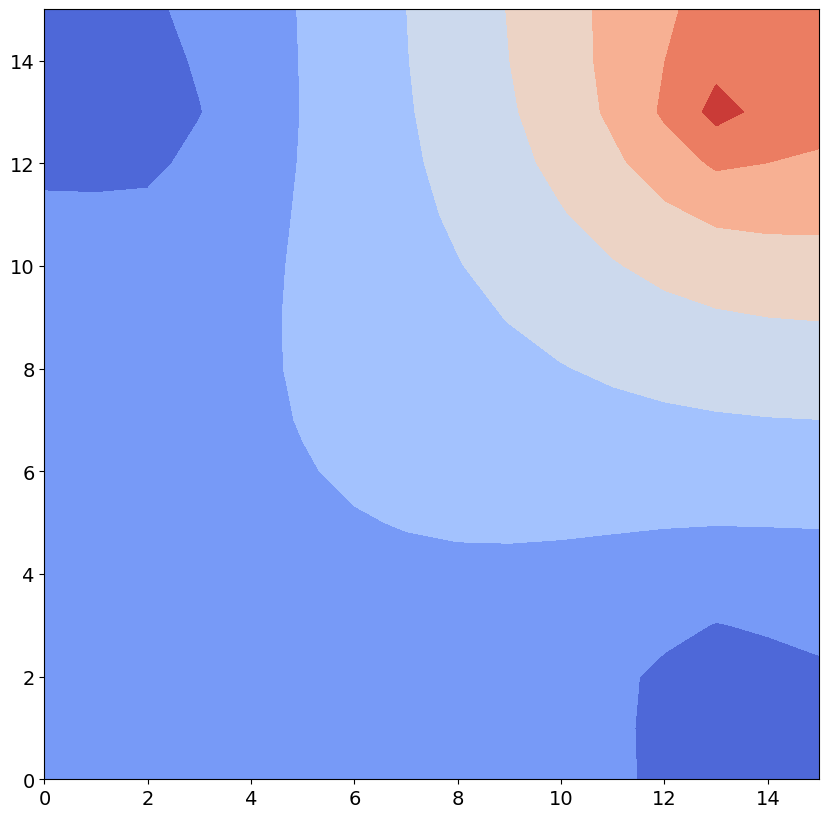

In [12]:
p_mat = Statistics.p_mat(State.p, BigClass.Variabs.NGrid)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# fig, ax = plt.subplots()

# Make data.
X = np.arange(np.shape(p_mat)[0])
Y = np.arange(np.shape(p_mat)[1])
X, Y = np.meshgrid(X, Y)

# Plot the surface.
plt.contourf(X, Y, p_mat, cmap=plt.cm.coolwarm,
         linewidth=0, antialiased=False)

print(p_mat)
print(p_mat[NGrid-row,NGrid-row])
print(p_mat[NGrid-row,row])
print(p_mat[row,NGrid-row])
print(p_mat[row,row])

In [13]:
# Save inportant data as CSV

# import pandas as pd 

datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# df1 = pd.DataFrame(u_allostery_arr)
# print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# df2 = pd.DataFrame(w_vec)
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")
df2 = pd.DataFrame(shear_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")

2024_04_07_13_08_21


In [14]:
# df2 = pd.DataFrame(w_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")

2024_04_07_13_08_21


NameError: name 'sns' is not defined

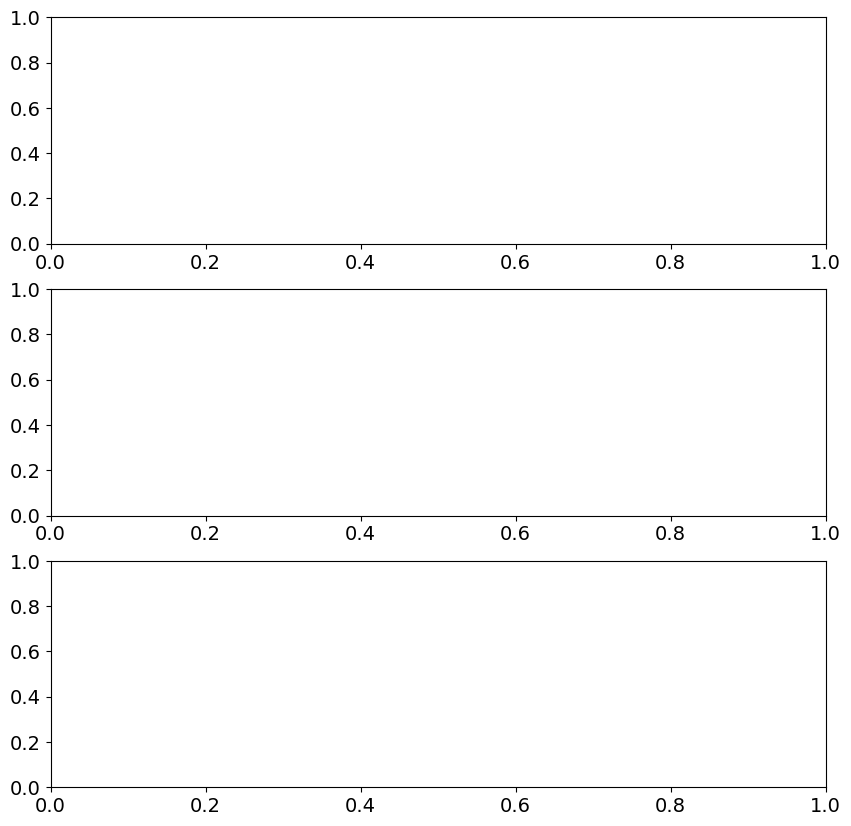

In [15]:
## Figures

# prelims for figures
datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# fig 1 - MSE, Hamming and Power dissip. afo p

fig1, axes1 = plt.subplots(nrows=3)
# axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# cmap = plt.get_cmap('cool')
cmap = sns.cubehelix_palette(as_cmap=True)
colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
legend_every = 10

for i, color in enumerate(colors, start=0):
    if i % legend_every == 0:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
    else:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
    axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
    axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
axes1[0].legend()
# plt.show()
axes1[2].set_xlabel('iteration #')
axes1[0].set_ylabel('flow MSE')
axes1[1].set_ylabel('Hamming dist.')
axes1[2].set_ylabel('power')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# fig 2 - # cycles until convergence and tau p

fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
axes2[0].set_ylabel('# cycles')
# axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\theta$')
axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
axes2[1].set_ylabel('$\\tau$')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

In [ ]:
State.u_final

In [ ]:
np.mean(np.abs(State.u))*NGrid**2
# R_typ1 = (1/1 + 1/K_min[0])**(-1) * (NGrid-(2*row))
R_typ2 = (1/1 + 1/1)**(-1) * (NGrid-(2*row))
R_typ1 = R_typ2
R_typ = (R_typ1 + R_typ2)/2
u_typ = input_p[0]/R_typ
print(u_typ)
print(w_vec)
print(w_vec/u_typ)

In [ ]:
# NGrid = 12
# u = State.u

NGrid = 2
row = 0
delta_p = 4
# u = np.array([1, 0, -1, 0, 2, 0, -2, 0, 3, 0, -3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
#               -3, 0, 3, 0, -2, 0, 2, 0, -1, 0, 1, 0])
# u = np.array([0, 1, 0, -1, 0, 0, 0, 0, 0, -3, 0, 3, 0 , 2, 0, -2, 0, 0, 0, 0, 0, -2, 0, 
#               2, 0, 3, 0, -3, 0, 0, 0, 0, 0, -1, 0, 1])
u = 1*np.array([0, 1, 0, -1, 0, -1, 0, 1, 0, 1, 0, -1, 0, -1, 0, 1])
print(np.size(u))
u_by_cells = np.zeros([NGrid*NGrid,2])
for i in range(NGrid*NGrid):
    u_by_cells[i,0] = (u[4*i]+(-u[4*i+2]))/2
    u_by_cells[i,1] = (u[4*i+1]+(-u[4*i+3]))/2
u_by_cells = np.reshape(u_by_cells, [NGrid, NGrid, 2])
u_by_cells_mag = np.sqrt(u_by_cells[:,:,0]**2+u_by_cells[:,:,1]**2)
    
print(u_by_cells_mag)
# R_typ = (1/1 + 1/1) * (NGrid-(2*row))
# u_typ = delta_p/R_typ
# print('u_typ %f' % u_typ)

w = Statistics.curl_direction(u, NGrid)
w_norm = w/u_typ
print('u %f' % np.mean(np.abs(u_by_cells_mag)))
print('w %f' % w)
print('w_norm %f' % w_norm)

# print('u_by_cells')
# print(u_by_cells[:,:,0])
# print(u_by_cells[:,:,1])

# dxuy = np.append(np.diff(u_by_cells[:,:,1],axis=1).T, [np.diff(u_by_cells[:,:,1],axis=1)[:,-1]], axis=0).T
# print('dxuy')
# print(dxuy)
# dyux = np.append(np.diff(u_by_cells[:,:,0],axis=0), [np.diff(u_by_cells[:,:,0],axis=0)[-1,:]], axis=0)
# print('dyux')
# print(dyux)
# curl = dxuy-dyux
# u_mean = np.mean(np.mean(np.abs(u_by_cells)))
# print('u_mean is %f' % u_mean)
# curl_norm = curl/u_mean
# print(curl_norm)
# print(np.mean(np.mean(curl_norm)))

### Main part - loop over many conductivity ratios

In [ ]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(K_min)])
# Hamming_arr = np.zeros([Variabs.iterations, len(K_min)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(K_min)])
# convergence_time_vec = np.zeros([len(K_min), ])
# shear_vec = np.zeros([len(K_min), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(K_min)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, K_min_i in enumerate(K_min):
    
#     # save variables into class
#     Variabs.assign_K_min(K_min_i)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='yes')
#     print(State.K)
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     # print(State.power_dissip)
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(K_min)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [ ]:
# print(np.mean(State.p))
# np.max(State.p)

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
# axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

### Main part - loop over many pressures

In [ ]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(input_p)])
# Hamming_arr = np.zeros([Variabs.iterations, len(input_p)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(input_p)])
# convergence_time_vec = np.zeros([len(input_p), ])
# # theta_vec = np.zeros([len(input_p), ])
# shear_vec = np.zeros([len(input_p), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(input_p)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, p in enumerate(input_p):
    
#     # save variables into class
#     Variabs.assign_input_p(p)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='no')
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', plot='no', savefig='no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(input_p)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [ ]:
# State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes', savefig='yes')

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='p='+str(input_p[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[i], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(input_p, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(input_p, np.zeros([len(input_p),]))
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

In [ ]:
# # Save inportant data as CSV

# # import pandas as pd 

# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # df1 = pd.DataFrame(u_allostery_arr)
# # print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# # df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# df2 = pd.DataFrame(np.array([K_min, convergence_time_vec, shear_vec]))
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")